In [2]:
from matplotlib_venn import venn2, venn3
import pandas as pd
import matplotlib.pyplot as plt

inherits = pd.read_csv('packageReach/inherits.csv')
setA = set(inherits["node.name"])

lodash = pd.read_csv('packageReach/lodash.csv')
setB = set(lodash["node.name"])

packages = pd.read_csv('packageReach/allPackages.csv')
setC = set(packages["n.name"])

# print(setA,setB,setC)

plt.figure(figsize=(8,6), dpi=100)
venn3([setA, setB, setC], ('inherits', 'lodash', 'All Packages'))
plt.savefig("packageReach/top2ReachPackages.png")

                 Value
Key                   
2010-11-01    1.000000
2010-12-01    1.000000
2011-01-01    1.533333
2011-02-01    2.764368
2011-03-01    3.823529
2011-04-01    4.495385
2011-05-01    4.830952
2011-06-01    5.405405
2011-07-01    6.651240
2011-08-01    7.289875
2011-09-01    8.031877
2011-10-01    8.753411
2011-11-01    9.393554
2011-12-01   10.815692
2012-01-01   11.248322
2012-02-01   11.884940
2012-03-01   13.714516
2012-04-01   14.375423
2012-05-01   15.181422
2012-06-01   16.306026
2012-07-01   18.216014
2012-08-01   19.791409
2012-09-01   20.930192
2012-10-01   23.339829
2012-11-01   24.822416
2012-12-01   26.390584
2013-01-01   27.059040
2013-02-01   27.321606
2013-03-01   26.599831
2013-04-01   32.623013
...                ...
2015-11-01  155.953729
2015-12-01  157.210132
2016-01-01  162.205836
2016-02-01  163.854205
2016-03-01  180.870292
2016-04-01  181.886631
2016-05-01  183.926773
2016-06-01  176.596771
2016-07-01  181.355831
2016-08-01  179.231887
2016-09-01 

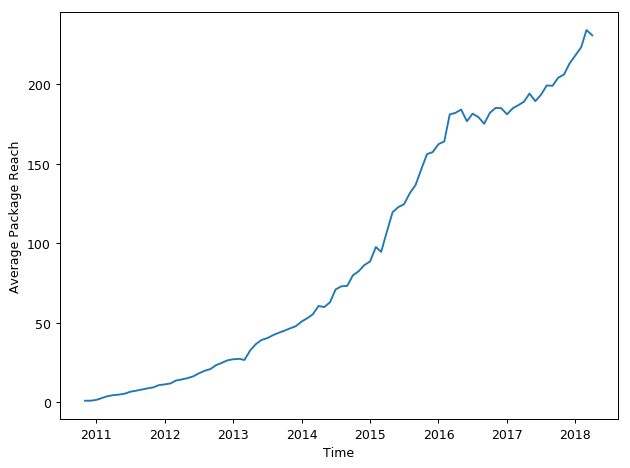

In [3]:
def transformDf(df, key):
    df[key] = pd.to_datetime(df[key])
    df = df.set_index(key)
    return df

# Reach
dataAvg = pd.read_json('averagePackageReach.json')
averagePackageReach = transformDf(dataAvg, "Key")

print(averagePackageReach)

plt.figure(figsize=(8,6), dpi=90)
plt.xlabel('Time')
plt.ylabel('Average Package Reach')
plt.plot(averagePackageReach["Value"])
plt.savefig("averagePackageReach.png")

SpearmanrResult(correlation=0.97936210131332091, pvalue=5.375398304237517e-28)
CPU times: user 454 ms, sys: 257 ms, total: 711 ms
Wall time: 388 ms


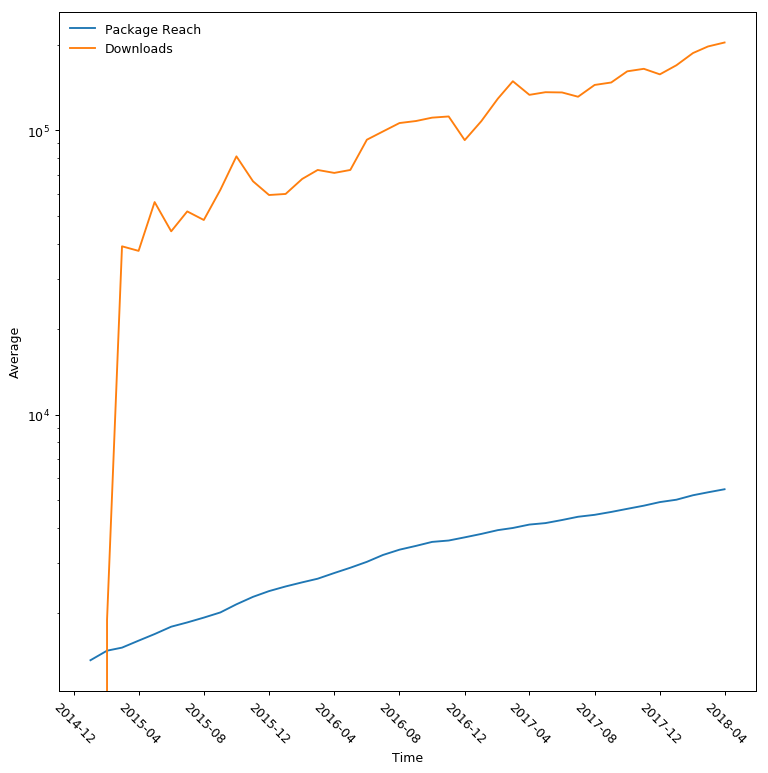

In [5]:
%%time
import scipy.stats
import math

def setIndexToDate(df, avg):
    avg["Key"] = pd.to_datetime(avg["Key"])
    df = df.set_index(avg["Key"])
    return df

dataAvg = pd.read_json('maintainerReach/averageMaintainerReach.json')

packageName = 'event-stream'
packageFileName = packageName.replace('/', '')

# Popularity (downloads) for one package
df = pd.read_json('popularity-average/{}/{}.json'.format(packageFileName[0], packageFileName))
downloads = transformDf(df, "Time")

# Package Reach for one Package
packageReach = pd.read_json('package-reach/{}/{}.json'.format(packageFileName[0], packageFileName))
packageReachDate = setIndexToDate(packageReach, dataAvg)
startTime = df.iloc[0]['Time']
endTime = df.iloc[-1]['Time']
startIndex = packageReachDate.loc[startTime]['X']
endIndex = packageReachDate.loc[endTime]['X']
packageReachTimeSpan = packageReachDate[startIndex:endIndex+1]

# Figure definition
plt.figure(figsize=(10,10), dpi=90)
plt.xlabel('Time')
plt.ylabel('Package Reach')
plt.plot(packageReachTimeSpan["Y"], label='Package Reach')
plt.xlabel('Time')
plt.ylabel('Average')
plt.xticks(rotation=-45)
plt.yscale('log')
plt.plot(downloads["Downloads"], label='Downloads')
plt.legend(loc='best', frameon=False)
plt.savefig("popularityBoost/{}.png".format(packageFileName))

spearman = scipy.stats.spearmanr(packageReachTimeSpan["Y"], downloads["Downloads"], nan_policy='omit')

if not math.isnan(spearman.correlation):
    print(spearman)

In [ ]:
# calculate spearman correlation between package reach and average number of downloads per month 

import scipy.stats

import warnings
warnings.filterwarnings(action='ignore')


def setIndexToDate(df, avg):
    avg["Key"] = pd.to_datetime(avg["Key"])
    df = df.set_index(avg["Key"])
    return df

dataAvg = pd.read_json('maintainerReach/averageMaintainerReach.json')

allPackageNames = pd.read_csv("allPackagesNames")

sumSpearman = 0
count = 0


def calculateCorrelation(packageName):
    packageFileName = packageName.replace('/', '')

    # Popularity (downloads) for one package
    df = pd.read_json('popularity-average/{}/{}.json'.format(packageFileName[0], packageFileName))
    downloads = transformDf(df, "Time")

    # Package Reach for one Package
    packageReach = pd.read_json('package-reach/{}/{}.json'.format(packageFileName[0], packageFileName))
    packageReachDate = setIndexToDate(packageReach, dataAvg)
    startTime = df.iloc[0]['Time']
    endTime = df.iloc[-1]['Time']
    startIndex = packageReachDate.loc[startTime]['X']
    endIndex = packageReachDate.loc[endTime]['X']
    packageReachTimeSpan = packageReachDate[startIndex:endIndex+1]

    spearman = scipy.stats.spearmanr(packageReachTimeSpan["Y"], downloads["Downloads"])
    return packageName, spearman
        
from concurrent.futures import ProcessPoolExecutor, as_completed
pool = ProcessPoolExecutor(4)
futures = []

for packageName in allPackageNames['Package']:
    futures.append(pool.submit(calculateCorrelation, packageName))

for x in as_completed(futures):
    spearman = x.result()[1]
    if not math.isnan(spearman.correlation):
        count = count + 1
        sumSpearman = sumSpearman + spearman.correlation
    else:
        print('{} has NaN correlation'.format(x.result()[0]))

9.29wookjiaxin has NaN correlation
@applantic/chips-select has NaN correlation
@domachine/cds-react-nifty has NaN correlation
@behance/jquery-simulate-ext has NaN correlation
@allthings/uuid has NaN correlation
9.28 has NaN correlation
@appkit/extension has NaN correlation
@domachine/cds-react has NaN correlation
@agilatech/rain has NaN correlation
@behance/jquery-simulate has NaN correlation
@allthings/tslint-preset has NaN correlation
@anejs/anne-plugin-typescript has NaN correlation
9.26 has NaN correlation
@appkit/cli has NaN correlation
@domachine/autotask has NaN correlation
@agilatech/mpu9250 has NaN correlation
@behance/jquery has NaN correlation
@allthings/renovate-config has NaN correlation
@anejs/anne-plugin-stylelint has NaN correlation
@babel/plugin-transform-jscript has NaN correlation
9.13 has NaN correlation
@appius-digital/task-lint-styles has NaN correlation
@dollarshaveclub/ui has NaN correlation
@behance/jasmine-vue has NaN correlation
@ambassify/vault-client has Na

@edelprino/now has NaN correlation
@emotionreader/ui has NaN correlation
@cliener/react-datepicker has NaN correlation
@chiiia12/dog-me has NaN correlation
@datafire/google_videointelligence has NaN correlation
20171127 has NaN correlation
@ericandrewlewis/bitmap has NaN correlation
@cenchat/core has NaN correlation
@eddystop/test-repo has NaN correlation
@cliener/git-merger has NaN correlation
@chihhunglin/seochecker has NaN correlation
@datafire/google_vault has NaN correlation
2017109liuhaotest has NaN correlation
@cenchat/cloud-firestore-model has NaN correlation
@ethanresnick/tslint-config has NaN correlation
@excellalabs/lodash-v2.4.1 has NaN correlation
@4geit/ngx-template has NaN correlation
@datafire/deutschebahn_reisezentren has NaN correlation
@browninglogic/ng-minimal-test-library has NaN correlation
556 has NaN correlation
@byteowls/ionic-hierarchical-menu has NaN correlation
@electorrent/node-rtorrent has NaN correlation
@datafire/google_games has NaN correlation
@ethanre

@adahealth/react-native-apple-healthkit has NaN correlation
@dstil/trello-data-provider has NaN correlation
@biofabrik/wastx-machine-server-shared has NaN correlation
@dosandk/shared-modules has NaN correlation
@aktr/node-module-a has NaN correlation
@adahealth/eslint-config has NaN correlation
@dstil/project-status has NaN correlation
@biodiversity/ssr-breakpoints has NaN correlation
@belong-ui/select-dropdown has NaN correlation
@dojo/interop has NaN correlation
@akst.io/stream-to-async-iterator has NaN correlation
@dortzur/react-tracking has NaN correlation
@adahealth/components has NaN correlation
@binpar/tsv-to-issues has NaN correlation
@dadi/web-handlebars has NaN correlation
@antv/g6-plugins has NaN correlation
@blokks.co/schedule has NaN correlation
@ambassify/ui-grid-flex has NaN correlation
@crossfield/react-timer-hoc has NaN correlation
@custom-element/nav-drawer has NaN correlation
@dadi/web-es6-templates has NaN correlation
@datafire/6_dot_authentiqio_appspot has NaN corr

@cnbritain/wc-digitaleditions-bbcode-gallery has NaN correlation
50-cinquante-nuances-plus-claires-film-complet-vf-hd has NaN correlation
@abbica/material has NaN correlation
@emotion/jest has NaN correlation
@clickopolis/app has NaN correlation
@example-org/example-package has NaN correlation
@cnbritain/wc-cookie-warning has NaN correlation
5.wei-jin-lin has NaN correlation
@abbica/charts has NaN correlation
@emotion/is-prop-valid has NaN correlation
@clickalicious/ci-github-bot has NaN correlation
@exah/tumblr-theme-parser has NaN correlation
5.js has NaN correlation
@abbica/cdk has NaN correlation
@emotion/global has NaN correlation
@cli-engine/util has NaN correlation
@esy-ocaml/merlin has NaN correlation
@exah/sticky-kit has NaN correlation
5.25search has NaN correlation
@abbhakan/hi-wasm has NaN correlation
@emotion/dynamic has NaN correlation
@cnbritain/wc-card-portrait has NaN correlation
@bufferapp/account-web has NaN correlation
5.11xixixi has NaN correlation
@emotion/css.mac

@cross2d/next has NaN correlation
@broid/callr has NaN correlation
@coupler/mid-typepool has NaN correlation
@dasnoo/arsocket-server has NaN correlation
@easy-webpack/config-typescript has NaN correlation
@cross2d/bugsnag-react-native has NaN correlation
@broid/api-sdk has NaN correlation
@coupler/mid-stopwatch has NaN correlation
@dasnoo/arsocket-client has NaN correlation
@dshaneg/text-adventure-core has NaN correlation
@easy-webpack/config-tslint has NaN correlation
@cross-check/dsl has NaN correlation
@broid/alexa has NaN correlation
@coupler/mid-router has NaN correlation
@dshaneg/generator-node-app has NaN correlation
@easy-webpack/config-test-coverage-istanbul has NaN correlation
@dadi/cli has NaN correlation
@blitt/good-influx has NaN correlation
12g has NaN correlation
@appbaseio/reactivebase-manual has NaN correlation
@comparaonline/react-apollo-2.0.4 has NaN correlation
@district01/ng-redux-router has NaN correlation
@dadi/cdn has NaN correlation
@blit/webgl has NaN correlat

@beisen/upass-user-selector has NaN correlation
@fangt/campfiremouseutil has NaN correlation
@alitaheri/material-ui-legacy has NaN correlation
@codext/stencil-components has NaN correlation
@aantthony/ioc has NaN correlation
@activix/bootstrap-datetimepicker has NaN correlation
@beauknowssoftware/ro has NaN correlation
@bvapps/bvue-date has NaN correlation
@beisen/upass-lookup-v2 has NaN correlation
@fangrong/xoc has NaN correlation
@alingenfelter/me has NaN correlation
@benchristel/supercrawler has NaN correlation
@codexp/timer has NaN correlation
@aantonov/redis-omapper has NaN correlation
@activewidgets/vue has NaN correlation
@beauknowssoftware/aws-lambda-elasticsearch has NaN correlation
@bvapps/bvue-cruds has NaN correlation
@fand/todo-slack has NaN correlation
@alingenfelter/foo5 has NaN correlation
@codexp/nw.tray-menu has NaN correlation
@activewidgets/react has NaN correlation
@beauknows/eslint-config-personal has NaN correlation
@bvanhoof/blockchain-exchange has NaN correlat

@antklim/api-to-cloud has NaN correlation
@datafire/visagecloud has NaN correlation
@aventure-cloud/vuejs-permission has NaN correlation
12345explore has NaN correlation
@codetector/pcsclite has NaN correlation
@antjoh/compliments has NaN correlation
@datafire/victorops has NaN correlation
@aventure-cloud/vuejs-local-storage-bridge has NaN correlation
12345abcdehaha has NaN correlation
@codetasty/collection-cluster has NaN correlation
@deathbeds/jyve-js-unsafe-extension has NaN correlation
@commodityvectors/react-mapbox-gl has NaN correlation
@antixrist/vue-flatpickr has NaN correlation
@datafire/vestorly has NaN correlation
@aventure-cloud/vuejs-axios-bridge has NaN correlation
123456gendiff123456 has NaN correlation
@codetakt/eslint-config has NaN correlation
@antistatique/sawi-styleguide has NaN correlation
@datafire/versioneye has NaN correlation
123456987456231 has NaN correlation
@codespec/react-toolset has NaN correlation
@antistatique/retraitespopulaires-styleguide has NaN corr

@avaly/connect-flash has NaN correlation
@datafire/swaggerhub has NaN correlation
@cotto/idb-wrapper-operations has NaN correlation
@cysonius/parameter-parser has NaN correlation
1221 has NaN correlation
@darrinholst/node-quickbooks has NaN correlation
@brittanica/v has NaN correlation
@conglomerate/history has NaN correlation
@avalcepina/how_to_npm has NaN correlation
@digix/react-webcam has NaN correlation
@datafire/swagger_generator has NaN correlation
@cotto/idb-wrapper has NaN correlation
@cysonius/mongo-utils has NaN correlation
12122 has NaN correlation
@darrinholst/mocha-webpack has NaN correlation
@brittanica/u has NaN correlation
@avalara/ava-nice-day-foundation has NaN correlation
@datafire/paypal has NaN correlation
12121 has NaN correlation
@darrinholst/hubot-wolfram has NaN correlation
@brittanica/t has NaN correlation
@conglomerate/exchange has NaN correlation
@avalanche/utility-width has NaN correlation
@digix/ipfs-pinning-registry has NaN correlation
@cotto/component-u

@cdp/lazyload has NaN correlation
@achingbrain/nss has NaN correlation
@aeternity/conversational-machine has NaN correlation
@drinky78/radomodule has NaN correlation
@bam.tech/react-native-fast-image has NaN correlation
@a-sync/opencv4nodejs has NaN correlation
@aliadosweb/kurento-sel has NaN correlation
@b0ulzy/password-generator has NaN correlation
@datafire/google_deploymentmanager has NaN correlation
@bristolinfotech/redux-modals has NaN correlation
@achingbrain/node-syslog has NaN correlation
@aeternity/aepp-sdk has NaN correlation
@drinky78/assets-service has NaN correlation
@arist0tl3/mongodb-prebuilt has NaN correlation
@akashic/akashic-cli has NaN correlation
@andreasgalster/fsn-messaging-input has NaN correlation
@avalanche/utility-offset has NaN correlation
@domp/create-many has NaN correlation
@economist/component-silver-bullet has NaN correlation
@beacon/threadneedle has NaN correlation
@eastwest/cli has NaN correlation
@bigfishtv/react-forms has NaN correlation
@akashic-e

@brycemarshall/autocomplete-ionic has NaN correlation
@atu/url-query has NaN correlation
@cinchapi/url-transform has NaN correlation
720vod-locker-cinquanta-sfumature-di-rosso has NaN correlation
@datafire/google_cloudmonitoring has NaN correlation
@evo/event-channel has NaN correlation
@bcoe/test-dep-5 has NaN correlation
@emdaer/plugin-documentation has NaN correlation
@button/minquery has NaN correlation
@atu/clone has NaN correlation
@cimpresscloud/metafig has NaN correlation
720-loading has NaN correlation
@datafire/google_cloudkms has NaN correlation
@evo/eslint-config-uaprom has NaN correlation
@bcoe/test-alternate-main has NaN correlation
@emdaer/plugin-details has NaN correlation
@button/divvy-client has NaN correlation
@brycehanscomb/oversee-promise has NaN correlation
@f/border-styles has NaN correlation
@atto/track-logs has NaN correlation
@essential-projects/http_integration_testing has NaN correlation
@cimpresscloud/ecs-publish has NaN correlation
718 has NaN correlation


@buttercup/datasources has NaN correlation
@cantremember/mockgoose has NaN correlation
@aitor-nestor-omar/ull-shape-triangle has NaN correlation
@dysfunctionl/adonis-watchtower has NaN correlation
@accounts/oauth-instagram has NaN correlation
@creditkarma/dynamic-config has NaN correlation
@azure-iot/authentication has NaN correlation
@datafire/azure_sql_metrics has NaN correlation
@datafire/google_blogger has NaN correlation
@arve.knudsen/fun-component has NaN correlation
@bharat67/people has NaN correlation
@buttercup/credentials has NaN correlation
@cantina/style-guide has NaN correlation
@arve.knudsen/choo has NaN correlation
@beisen/react-quill has NaN correlation
@dysfunctionl/adonis-grapple has NaN correlation
@azu/textlint-config-readme has NaN correlation
@accounts/oauth has NaN correlation
@datafire/google_bigquerydatatransfer has NaN correlation
@datafire/azure_sql_manageddatabases has NaN correlation
@bhamcoder/promise-ftp has NaN correlation
@cansat-icarus/capture-lib has 

@codeftw/future-web-ui-alert has NaN correlation
@cond/last-fm has NaN correlation
@davvo/worker-pool has NaN correlation
@eigenjoy/cq has NaN correlation
2gendiff123456 has NaN correlation
@cmd/utils has NaN correlation
@deskpro/deskpro-api-client-javascript has NaN correlation
@codeftw/future-web-graphql-date-time-resolver has NaN correlation
@cond/jquery-autocomplete has NaN correlation
@davvo/drbx has NaN correlation
@ehyland-org/react-scripts has NaN correlation
@cmd/usage has NaN correlation
@deskpro/apps-sdk-react has NaN correlation
2gendiff has NaN correlation
@codefresh-io/yaml-validator has NaN correlation
@cond/express-session has NaN correlation
@davvo/ak-styles has NaN correlation
@ehyland-org/react-error-overlay has NaN correlation
@cmd/run has NaN correlation
@atomix-ui/core has NaN correlation
2gen_modules has NaN correlation
@codefresh-io/test-utils has NaN correlation
@davvo/ak-proj has NaN correlation
@ehyland-org/react-dev-utils has NaN correlation
@cmd/handler has

@bewm/sample has NaN correlation
@embedded-enterprises/dot-cli has NaN correlation
@canner/slate-icon-image has NaN correlation
@airtoxin/clow-template-babel has NaN correlation
@123test456/test-scoped has NaN correlation
@alu0100973914/colorcell-oop-plugin has NaN correlation
@brigad/redux-rest-easy has NaN correlation
@advanced-rest-client/request-hooks-logic has NaN correlation
@datafire/google-translate has NaN correlation
@bbarker/collection has NaN correlation
@automaid/scenes-service has NaN correlation
@bewithjonam/mapboxgl-spiderifier has NaN correlation
@embarq/ngx-accordion has NaN correlation
@canner/slate-icon-hr has NaN correlation
@bridg/bridg-react-components has NaN correlation
@123samir/temp-login has NaN correlation
@aduth/eslint-config has NaN correlation
@alu0100973914/auth has NaN correlation
@datafire/google-toolresults has NaN correlation
@automaid/rss-service has NaN correlation
@bbalganjjm/natural_js has NaN correlation
@bewithjonam/mapbox-gl has NaN correlati

@datafire/nytimes_article_search has NaN correlation
@code-therapy/packages-with-readme-relative-images has NaN correlation
6.10test has NaN correlation
@datafire/nytimes_archive has NaN correlation
@derhuerst/level-tree has NaN correlation
@code-o-mat/method-o-mat has NaN correlation
@eventstorejs/graphql has NaN correlation
6.10 has NaN correlation
@eslib/cli has NaN correlation
@datafire/nytimes-top_stories has NaN correlation
@bahmutov/add-typescript-to-cypress has NaN correlation
@built/react-scripts has NaN correlation
@clubajax/react-inject-change-events has NaN correlation
2d-mat has NaN correlation
@castery/caster-telegram has NaN correlation
@emartech/easy-crypto has NaN correlation
@bagubagu/utils has NaN correlation
@faast/ethereum-payments has NaN correlation
@buildo/hophop has NaN correlation
@clubajax/react-custom-element-attributes has NaN correlation
2d-gl has NaN correlation
@castery/caster-discord has NaN correlation
1click-api has NaN correlation
@bagubagu/users has

@copoch/tesla-template-react has NaN correlation
@araulet/express-routes-loader has NaN correlation
@copoch/tesla-template-middleware has NaN correlation
@crave/farmblocks-tags has NaN correlation
@aranja/react-scripts has NaN correlation
@copoch/tesla-template-html5 has NaN correlation
@crave/farmblocks-table has NaN correlation
@aragonite/vbox-runner has NaN correlation
@colmena/api has NaN correlation
@cybernaut/puppeteer has NaN correlation
@crave/farmblocks-stepper has NaN correlation
@aragon/wrapper has NaN correlation
@copoch/tesla has NaN correlation
@cybernaut/mocks has NaN correlation
@crave/farmblocks-scaffold has NaN correlation
@angular/material-experimental has NaN correlation
@aragon/web has NaN correlation
@coorpacademy/update-node has NaN correlation
@cybernaut/engine has NaN correlation
@crave/farmblocks-removable-tags has NaN correlation
@aragon/ui has NaN correlation
@crave/farmblocks-more-info has NaN correlation
@aragon/test-helpers has NaN correlation
@colmena/ad

@cloudwalker/eslint-config has NaN correlation
@dicebear/avatars-identicon-sprites has NaN correlation
@egeria/discord-plugin has NaN correlation
@cloudwalker/create-web-app has NaN correlation
5c6jl_webpack_button has NaN correlation
@dicebear/avatars-female-sprites has NaN correlation
@egeria/calendar-plugin has NaN correlation
1731 has NaN correlation
@cloudux/noah-theme has NaN correlation
5blayer has NaN correlation
@deck/example-deck has NaN correlation
@dicebear/avatars has NaN correlation
1722-wyg has NaN correlation
@cloudux/ca has NaN correlation
5argon-react-scripts has NaN correlation
@dicarlo/knex has NaN correlation
1720yuchen has NaN correlation
@cloudtea/react-native-smartlink has NaN correlation
5aces-service-root has NaN correlation
@diaspora/diaspora has NaN correlation
@egeria/archive-plugin has NaN correlation
1720demo has NaN correlation
@cloudtea/react-native-cordova has NaN correlation
5aces-service-registry has NaN correlation
@deck/app has NaN correlation
@dia

@csgis/json-module-args-loader has NaN correlation
@datafire/amazonaws_mgh has NaN correlation
@bentatum/vue-material has NaN correlation
@alex_toudic/wagner has NaN correlation
@alterior/testing has NaN correlation
@ampatspell/ember-cli-strings has NaN correlation
@angular-package/core has NaN correlation
@csgis/geoladris-ui has NaN correlation
@datafire/amazonaws_metering_marketplace has NaN correlation
@bentatum/rebass has NaN correlation
@ahmadnassri/debug has NaN correlation
@dword-design/cli has NaN correlation
@alex_toudic/markerclustererplus has NaN correlation
@alterior/mongo has NaN correlation
@ampatspell/ember-cli-sofa has NaN correlation
@csgis/di has NaN correlation
@datafire/amazonaws_mediastore has NaN correlation
@bentatum/react-router-redux has NaN correlation
@ahmadnassri/babel-build-all has NaN correlation
@dwolla/eslint-config-dwolla has NaN correlation
@alex_roman/prima-componenta-stencil has NaN correlation
@ampatspell/ember-cli-relax-session has NaN correlation


@choojs/nanocache has NaN correlation
@elium/mighty has NaN correlation
@enmaso/node-convert has NaN correlation
@ert78gb/angular-2-dropdown-multiselect has NaN correlation
@fictiv/gravatar-api has NaN correlation
@effectful/cc has NaN correlation
23mofang-react-native-camera has NaN correlation
@choojs/findup has NaN correlation
@fav/prop.pick-deep has NaN correlation
@enlightenmentor/behave.js has NaN correlation
@ersulba/platzom has NaN correlation
@fictiv/falcor has NaN correlation
@effectful/babel-preset-env has NaN correlation
23mofang-react-native-autoheight-webview has NaN correlation
@choo/template-lite has NaN correlation
@fav/prop.pick has NaN correlation
@enkrateia/firstnpm has NaN correlation
@ersinfotech/wordcount has NaN correlation
@fictiv/eslint-plugin-import has NaN correlation
@effco/zoho-crm has NaN correlation
@eliperkins/downshift has NaN correlation
23mofang-qrconde-scan-style has NaN correlation
@choo/cli has NaN correlation
@fav/prop.omit-deep has NaN correlati

@dpogue/cordova-plugin-crosswalk-webview has NaN correlation
@aptas/eslint-config-apt-react has NaN correlation
@baumi/angular2-select has NaN correlation
@domoinc/ca-male-percent-gauge-banner has NaN correlation
@datafire/amazonaws_kinesis has NaN correlation
@cw-types/colors has NaN correlation
@dpogue/cordova-android has NaN correlation
@baum/passport-http has NaN correlation
@datafire/amazonaws_iot has NaN correlation
@cw-types/chalk has NaN correlation
@dpc-sdp/ripple-primary-navigation has NaN correlation
@apsknight/jupyterlab_xkcd has NaN correlation
@baum/maple-ui has NaN correlation
@domoinc/ca-gauge-with-text has NaN correlation
@datafire/amazonaws_inspector has NaN correlation
@domoinc/ca-filled-image-and-summary-number has NaN correlation
@dpc-sdp/ripple-global has NaN correlation
@apsis/tslint-config-common has NaN correlation
@bauerpub/bauer-draft-js-utils has NaN correlation
@domoinc/ca-digital-clock-with-text has NaN correlation
@datafire/amazonaws_importexport has NaN 

@asymmetrik/ngx-instrumentation has NaN correlation
@doughtnerd/jade-stringifier has NaN correlation
@alpacka/plugin-graphql has NaN correlation
@aldendaniels/react-scripts has NaN correlation
@datafire/gettyimages has NaN correlation
@agily/af-aurelia-controls has NaN correlation
@blueeast/bluerain-plugin-bootstrap has NaN correlation
@brandify/node-api has NaN correlation
@damianobarbati/jss-reset has NaN correlation
@asymmetrik/mongoose-query-service has NaN correlation
@doublifyapis/filtering has NaN correlation
@conversationai/moderator-cli has NaN correlation
@alpacka/plugin-express has NaN correlation
@aldendaniels/lebab has NaN correlation
@datafire/getsandbox has NaN correlation
@dutchfurniturefulfilment/skik-client has NaN correlation
@agilie/ng2-dialog-window has NaN correlation
@blueeast/bluerain-plugin-apollo-link-ws has NaN correlation
@brandify/location has NaN correlation
@asymmetrik/leaflet-filter has NaN correlation
@doubleswirve/quarterback has NaN correlation
@alpac

@eeegor/react-components has NaN correlation
@eugenesia/my-awesome-nodejs-module has NaN correlation
@cezaraugusto/venus has NaN correlation
@4geit/rct-landing-page-layout-component has NaN correlation
@adler-it/reactant-modularis has NaN correlation
@agilatech/zetta-cozir5-linux-driver has NaN correlation
@edy/sails-hook-resque has NaN correlation
@eng1neer/web-scraper-chrome-extension has NaN correlation
@euctrl-pru/website-build has NaN correlation
@cextakkaya/logger has NaN correlation
@4geit/rct-header-component has NaN correlation
@adler-it/logger has NaN correlation
@agilatech/zetta-bmp183-linux-driver has NaN correlation
@eng1neer/selectorgadget has NaN correlation
@edy/redux-api-middleware has NaN correlation
@etu/simditor-markdown has NaN correlation
@cexrreabel/reab-module has NaN correlation
@4geit/rct-footer-component has NaN correlation
@adler-it/dotnet-api has NaN correlation
@edx/stylelint-config-edx has NaN correlation
@eng1neer/material-ui-build has NaN correlation
@e

@ffra/autorun has NaN correlation
@dustinws/zoom has NaN correlation
@aureooms/js-integer has NaN correlation
@devinit/dh-app has NaN correlation
1510bwangyaliday4 has NaN correlation
@aureooms/js-int64 has NaN correlation
1510bwangdawei has NaN correlation
@dustinws/watts has NaN correlation
@aureooms/js-int32 has NaN correlation
1510ajiaozhen has NaN correlation
@compodoc/ts-stats has NaN correlation
@aureooms/js-in-situ-sort-spec has NaN correlation
@devinit/api-base has NaN correlation
1508bbwzhaoxiaodong has NaN correlation
@aureooms/js-hypermatrix has NaN correlation
@devin.argenta/filtermap has NaN correlation
1508bbw has NaN correlation
@aureooms/js-heapsort has NaN correlation
@device.farm/webglue has NaN correlation
1508aa has NaN correlation
@device.farm/silicon has NaN correlation
1508-cli has NaN correlation
@compodoc/ngd-cli has NaN correlation
@aureooms/js-heap-spec has NaN correlation
@device.farm/si-stm32f0x2 has NaN correlation
1507h has NaN correlation
@drifthq/draft

@files-stack/graphql-schema has NaN correlation
@filiosoft/rva-cli has NaN correlation
@filiosoft/cordova-plugin-progressindicator has NaN correlation
@filestore/memory has NaN correlation
@filestore/disk has NaN correlation
@filipdanic/dynameh has NaN correlation
@filou/antd has NaN correlation
@filipnest/filters has NaN correlation
@filou/calendar has NaN correlation
@filou/edits has NaN correlation
@filou/core has NaN correlation
@filou/icons has NaN correlation
@filou/cloudinary has NaN correlation
@filou/lightbox has NaN correlation
@filou/menu has NaN correlation
@filou/menu-dnd has NaN correlation
@filou/loader has NaN correlation
@filou/layout has NaN correlation
@filou/form has NaN correlation
@filou/portal has NaN correlation
@filou/menu-search has NaN correlation
@filou/menu-antd has NaN correlation
@filou/tabs has NaN correlation
@filou/slate has NaN correlation
@filou/upload has NaN correlation
@fimbul/heimdall has NaN correlation
@filou/updater has NaN correlation
@fimbul

@fredfogerty/np has NaN correlation
@fredfogerty/js-util has NaN correlation
@fredfogerty/ts-boilerplate has NaN correlation
@fredfogerty/js-cli has NaN correlation
@fredstrange/aws-xray-sdk has NaN correlation
@fredguile/hapi-sequelize has NaN correlation
@fredyc/draft-js-typeahead has NaN correlation
@fredstrange/aws-xray-sdk-restify has NaN correlation
@freebroccolo/atom-grammar-generator has NaN correlation
@fredyc/react-scripts-ts has NaN correlation
@fredstrange/sequelize-mock has NaN correlation
@freebroccolo/flow-chalk has NaN correlation
@freebroccolo/promise-bag has NaN correlation
@fredyc/mobx-react has NaN correlation
@freebroccolo/flow-shelljs has NaN correlation
@freedomds/shared-datastore has NaN correlation
@freebroccolo/shelljs-promises has NaN correlation
@freedombase/react-intl has NaN correlation
@freedomofspeech/chrome-extension has NaN correlation
@freedomds/shared has NaN correlation
@freedomds/shared-angular-utility has NaN correlation
@freeletics/react-slick ha

@fuselab/ui-fabric has NaN correlation
@fuselab/ui-shared has NaN correlation
@fusionary/postcss-config has NaN correlation
@fusebot/goterram has NaN correlation
@fusionary/postcss-base has NaN correlation
@fusionary/stylelint-config has NaN correlation
@fusionstrings/babel-preset-fusionstrings has NaN correlation
@fusionstrings/eslint-config has NaN correlation
@futpib/tika-server-client has NaN correlation
@futrium/cli has NaN correlation
@futpib/d has NaN correlation
@futpib/r-dom has NaN correlation
@futuregroup/webpack-custom-blocks has NaN correlation
@fuzeman/babel-plugin-module-resolver has NaN correlation
@fuzeman/eslint-import-resolver-babel-module has NaN correlation
@fv/rankit-widget has NaN correlation
@fuzzy-ai/microservice has NaN correlation
@fxreact/core has NaN correlation
@fweinb/electron-prebuilt has NaN correlation
@fweb/react-pagination has NaN correlation
@fyresite/aws-logger has NaN correlation
@fyresite/digisigner-js has NaN correlation
@fyresite/react-async-co

@gctools-components/language-selector has NaN correlation
@gctools-components/react-i18n-edit has NaN correlation
@gctools-components/react-gc-orgchart has NaN correlation
@gctools-components/recommendation-card has NaN correlation
@gd-uikit/breadcrumb has NaN correlation
@gd-uikit/button has NaN correlation
@gd-uikit/datepicker has NaN correlation
@gd-uikit/badge has NaN correlation
@gd-uikit/checkbox has NaN correlation
@gd-uikit/input has NaN correlation
@gd-uikit/dropdown has NaN correlation
@gd-uikit/icon has NaN correlation
@gd-uikit/modal has NaN correlation
@gd-uikit/label has NaN correlation
@gd-uikit/pagination has NaN correlation
@gd-uikit/message has NaN correlation
@gd-uikit/slider has NaN correlation
@gd-uikit/menu has NaN correlation
@gd-uikit/radio has NaN correlation
@gd-uikit/popover has NaN correlation
@gd-uikit/utils has NaN correlation
@gd-uikit/select has NaN correlation
@gd-uikit/toggle has NaN correlation
@gd-uikit/tooltip has NaN correlation
@gd-uikit/uikit has

@geo-maps/earth-lands-25m has NaN correlation
@geo-maps/earth-lands-500m has NaN correlation
@geo-maps/earth-rivers-10m has NaN correlation
@geo-maps/earth-rivers-100m has NaN correlation
@geo-maps/earth-lands-5km has NaN correlation
@geo-maps/earth-rivers-250m has NaN correlation
@geo-maps/earth-lands-5m has NaN correlation
@geo-maps/earth-rivers-25m has NaN correlation
@geo-maps/earth-rivers-1km has NaN correlation
@geo-maps/earth-rivers-1m has NaN correlation
@geo-maps/earth-rivers-2km5 has NaN correlation
@geo-maps/earth-rivers-10km has NaN correlation
@geo-maps/earth-rivers-2m5 has NaN correlation
@geo-maps/earth-rivers-5km has NaN correlation
@geo-maps/earth-rivers-500m has NaN correlation
@geo-maps/earth-seas-10km has NaN correlation
@geo-maps/earth-rivers-50m has NaN correlation
@geo-maps/earth-rivers-5m has NaN correlation
@geo-maps/earth-seas-100m has NaN correlation
@geo-maps/earth-seas-250m has NaN correlation
@geo-maps/earth-seas-2m5 has NaN correlation
@geo-maps/earth-sea

@gfpacheco/react-jss has NaN correlation
@ggallon/react-komposer has NaN correlation
@ggallon/react-simple-di has NaN correlation
@ggcity/map-viewer has NaN correlation
@gglib/content has NaN correlation
@gglib/input has NaN correlation
@gglib/core has NaN correlation
@gglib/ecs has NaN correlation
@gglib/graphics has NaN correlation
@gglib/math has NaN correlation
@gglib/gglib has NaN correlation
@ggoering/complete-me has NaN correlation
@gglib/render has NaN correlation
@ghasemkiani/commonbase has NaN correlation
@ghd/core-ui has NaN correlation
@gglib/terrain has NaN correlation
@ghd/core has NaN correlation
@ghalex/parse has NaN correlation
@ghgtech/styleguide has NaN correlation
@ghostgroup/grid-styled has NaN correlation
@ghostcode/shared-components has NaN correlation
@ghinwa/ghinwa-rn-audio-session-manager has NaN correlation
@ghostcode/ghostcode-react-scripts has NaN correlation
@ghinwa/react-native-audio-session-manager has NaN correlation
@ghinwa/react-native-preview-audio-p

@gleez/pjax has NaN correlation
@glenjamin/simple-sse has NaN correlation
@glencfl/tslint-config has NaN correlation
@glenjamin/eslint-config has NaN correlation
@glenjamin/inspect-x has NaN correlation
@glennsl/bs-revamp has NaN correlation
@glezsosa/video has NaN correlation
@glennsl/rebug has NaN correlation
@glidejs/glide has NaN correlation
@glezsosa/videojs-hola-skin has NaN correlation
@glimmer/application-test-helpers has NaN correlation
@glimmer/build has NaN correlation
@glimmer/blueprint has NaN correlation
@glimmer/dom-change-list has NaN correlation
@glimmer/public-runtime has NaN correlation
@glimmer/ssr has NaN correlation
@glimmer/web-component has NaN correlation
@glimpse/glimpse-definitions has NaN correlation
@glintcms/scope has NaN correlation
@glitchapp/cli has NaN correlation
@glitz/length-transformer has NaN correlation
@glitz/devtool-transformer has NaN correlation
@glitz/react has NaN correlation
@glitz/prefixer-transformer has NaN correlation
@gloat/shared-com

@google-cloud/dataproc has NaN correlation
@google-cloud/connect-datastore has NaN correlation
@google-cloud/container has NaN correlation
@google-cloud/nodejs-repo-tools has NaN correlation
@google-cloud/os-login has NaN correlation
@google-cloud/profiler has NaN correlation
@google-cloud/rcloadenv has NaN correlation
@google-cloud/text-to-speech has NaN correlation
@google/clasp has NaN correlation
@gopalroy/active-obd has NaN correlation
@google/earthengine has NaN correlation
@gopato/babel-preset-node has NaN correlation
@gopato/eslint-config-js has NaN correlation
@gopvup/login_test has NaN correlation
@gorangajic/bull-arena has NaN correlation
@gopato/sequelize-transforms has NaN correlation
@gopato/babel-preset-browser has NaN correlation
@gopato/graphql has NaN correlation
@gorangajic/react-soundcloud-widget has NaN correlation
@gorangajic/react-native-markdown has NaN correlation
@gorangajic/chromeless has NaN correlation
@gorangajic/material-ui has NaN correlation
@gorillab/c

@green-arrow/react-firestore has NaN correlation
@greendou/react-native-typescript-transformer has NaN correlation
@grebaldi/component-factory has NaN correlation
@greenbanana/ms-services has NaN correlation
@greenhousegames/firebase-waiting-room has NaN correlation
@greenek/grunt-svg-symbols has NaN correlation
@greendou/rollup-plugin-tslint has NaN correlation
@greenkeeper/content has NaN correlation
@greenheck/dap-util has NaN correlation
@greenlight/cli has NaN correlation
@greenlight/config-loader has NaN correlation
@greenlight/schema-plugin has NaN correlation
@greenlight/renovate-config has NaN correlation
@greenlight/schema-report has NaN correlation
@greenlight/docker has NaN correlation
@greenlight/plugin has NaN correlation
@greenlight/schema-config has NaN correlation
@greg-md/ng-elevator has NaN correlation
@greg-md/ng-boot has NaN correlation
@greg-md/ng-flex-css-layout has NaN correlation
@greg-md/ng-lazy-load has NaN correlation
@greg-md/ng-facebook has NaN correlation

@gzzhanghao/mocker has NaN correlation
@gzzhanghao/jsdom has NaN correlation
@gzzhanghao/exec has NaN correlation
@gzzhanghao/mk has NaN correlation
@gzzhanghao/docx2quill has NaN correlation
@gzzhanghao/dns-resolve-polyfill has NaN correlation
@gzzhanghao/mocker-utils has NaN correlation
@gzzhanghao/quill has NaN correlation
@gzzhanghao/quill-image-resize-module has NaN correlation
@gzzhanghao/quill-docx has NaN correlation
@gzzhanghao/quill2docx has NaN correlation
@gzzhanghao/unpack has NaN correlation
@gzzhanghao/worker-farm has NaN correlation
@gzzhanghao/vue-compiler has NaN correlation
@gzzhanghao/quill-export has NaN correlation
@h2w/h2logger has NaN correlation
@h3/eslint-config has NaN correlation
@gzzhanghao/x has NaN correlation
@h3/mucky has NaN correlation
@haakma-org/molgenis-vue-forms has NaN correlation
@haaretz/fela-utils has NaN correlation
@haaretz/commitlint-config has NaN correlation
@haaretz/htz-react-base has NaN correlation
@haaretz/react-utils has NaN correlat

@hashicorp/hashi-hero has NaN correlation
@hashicorp/hashi-logo-grid has NaN correlation
@hashicorp/hashi-section-header has NaN correlation
@hashicorp/hashi-image has NaN correlation
@hashicorp/hashi-secondary-nav has NaN correlation
@hashicorp/hashi-nav has NaN correlation
@hashicorp/hashi-packages has NaN correlation
@hashicorp/hashi-person-list has NaN correlation
@hashicorp/hashi-text-and-image has NaN correlation
@hashicorp/hashi-social-share-links has NaN correlation
@hashicorp/hashi-two-column-text has NaN correlation
@hasnat/graph.ql has NaN correlation
@hasnat/babel-plugin-transform-imports has NaN correlation
@hashrock/formula has NaN correlation
@hashstack/node-injection has NaN correlation
@hasnat/react-upload-file has NaN correlation
@hashtaagco/trimbody has NaN correlation
@haskkor/react-native-pincode has NaN correlation
@hasnat/redux-modules has NaN correlation
@hasnat/redux-injector has NaN correlation
@hassan99/seventh-project has NaN correlation
@hassan99/eight has 

@hemulit/cws-publish has NaN correlation
@hendrang/math_example has NaN correlation
@henderea/react-form-controls has NaN correlation
@henderea/static-site-builder has NaN correlation
@hendrikprinsza/basic-tts-player has NaN correlation
@heneise/joi-to-swagger has NaN correlation
@hendrichbenjamin/raider has NaN correlation
@hentamine/imp has NaN correlation
@henninghall/react-native-date-picker has NaN correlation
@henningm/mp4-stream has NaN correlation
@henrikjoreteg/rollup-plugin-css has NaN correlation
@henteko/livephotoskit-react has NaN correlation
@heq/server-redis has NaN correlation
@hentamine/lunar has NaN correlation
@herablog/workbox-background-sync has NaN correlation
@herbis/ngx-modal has NaN correlation
@herablog/workbox-build has NaN correlation
@herd/angular-client has NaN correlation
@herd/angularjs-client has NaN correlation
@herd/herd-ui-dist has NaN correlation
@herd/node-client has NaN correlation
@heroesbrowser/mpq has NaN correlation
@hermanscheer/hs-plugins ha

@hmcts/nodejs-healthcheck has NaN correlation
@hmcts/one-per-page has NaN correlation
@hmcts/postcodeinfo-client has NaN correlation
@hmcts/requestretry has NaN correlation
@hmcts/nodejs-logging has NaN correlation
@hmcts/tech-docs has NaN correlation
@hmps/pj has NaN correlation
@hn3000/argus has NaN correlation
@hmudesign/emitter has NaN correlation
@hn3000/metaapi has NaN correlation
@hn3000/react-stockcharts has NaN correlation
@hn3000/metamodel-react has NaN correlation
@hn3000/swagger-example-generator has NaN correlation
@hn3000/systemjs-jsonschema-loader has NaN correlation
@hn3000/webpack-jsonschema-loader has NaN correlation
@hn3000/swagger-optimizer has NaN correlation
@hnct/uicommon has NaN correlation
@hna-doudou/doudou-sdk has NaN correlation
@hnordt/reax-async has NaN correlation
@hnordt/reax-checkbox has NaN correlation
@hnordt/reax-date-input has NaN correlation
@hnordt/reax-button has NaN correlation
@hnordt/reax-col has NaN correlation
@hnordt/reax-autocomplete has N

@hoodie/task-server has NaN correlation
@hoolymama/date-util has NaN correlation
@hoolymama/bollocks has NaN correlation
@hoolymama/gis-util has NaN correlation
@hoolymama/natlang has NaN correlation
@hope/cors has NaN correlation
@hoolymama/pomtime has NaN correlation
@hope/error has NaN correlation
@hopin/logger has NaN correlation
@hora/http-response has NaN correlation
@hoolymama/jdb-utils has NaN correlation
@hoolymama/react-native-image-cropper has NaN correlation
@hora/transducers has NaN correlation
@hora/range has NaN correlation
@horacehylee/api-error-handler has NaN correlation
@horacehylee/firebase-db has NaN correlation
@horchatajs/hjs-multiselect has NaN correlation
@horacehylee/react-app-rewire-css-modules has NaN correlation
@horacehylee/flexbox-react has NaN correlation
@horacehylee/swiper has NaN correlation
@horizonfour/hapi-logger has NaN correlation
@horizontal/sample has NaN correlation
@horseman/components has NaN correlation
@horseman/server has NaN correlation


@humanmade/cli has NaN correlation
@huiyu/string-template has NaN correlation
@humanmade/nova-icons has NaN correlation
@humanmade/cf-to-tf has NaN correlation
@humans/action-sheet has NaN correlation
@humanmade/repress has NaN correlation
@humans/assistive-bar has NaN correlation
@humans/alert has NaN correlation
@humans/article has NaN correlation
@humans/carousel has NaN correlation
@humans/confirm has NaN correlation
@humans/checkbox has NaN correlation
@humans/counter has NaN correlation
@humans/core has NaN correlation
@humans/datetime has NaN correlation
@humans/input has NaN correlation
@humans/loading-bar has NaN correlation
@humans/loading-mask has NaN correlation
@humans/menu has NaN correlation
@humans/modal has NaN correlation
@humans/nav-bar has NaN correlation
@humans/paginate has NaN correlation
@humans/search-bar has NaN correlation
@humans/rate has NaN correlation
@humans/select has NaN correlation
@humans/suite has NaN correlation
@humans/tab-bar has NaN correlation


@iatec/ng2-status-bubble has NaN correlation
@iatec/ng2-quill-editor has NaN correlation
@iatec/ng2-treeview has NaN correlation
@ibamboo/log has NaN correlation
@iatec/ng2-timepicker has NaN correlation
@iawaknahc/react-scripts has NaN correlation
@iatec/ng2-wizard has NaN correlation
@ibamboo/rpi.js has NaN correlation
@ibamboo/trap has NaN correlation
@ibge/noticias has NaN correlation
@ibapt/icomp-core has NaN correlation
@ibge/calendario has NaN correlation
@ibm-design/charts-line has NaN correlation
@ibezkrovnyi/tslint-rules has NaN correlation
@ibm-functions/debugger has NaN correlation
@ibm-functions/composer has NaN correlation
@ibm-functions/shell has NaN correlation
@ibm-functions/shell-local-plugin has NaN correlation
@ibm-wch-sdk/iframe-component has NaN correlation
@ibm/motion has NaN correlation
@ibm/grid has NaN correlation
@ibm/plex has NaN correlation
@ibolmo/request has NaN correlation
@ibmblockchain/composer-playground has NaN correlation
@ibot/button has NaN correl

@icedesign/success-detail-block has NaN correlation
@icedesign/statistical-card-block has NaN correlation
@icedesign/step-form-block has NaN correlation
@icedesign/subscribe-block has NaN correlation
@icedesign/sortable-table-block has NaN correlation
@icedesign/tab-article-block has NaN correlation
@icedesign/system-notice-list-block has NaN correlation
@icedesign/success-dialog-block has NaN correlation
@icedesign/tab-dialog-block has NaN correlation
@icedesign/tab-chart-block has NaN correlation
@icedesign/terms-info-block has NaN correlation
@icedesign/tag-table-block has NaN correlation
@icedesign/team-display-block has NaN correlation
@icedesign/tab-table-block has NaN correlation
@icedesign/testimonial-block has NaN correlation
@icedesign/text-card-block has NaN correlation
@icedesign/tag-message-list-block has NaN correlation
@icedesign/text-search-list-block has NaN correlation
@icedesign/testimonial-card-block has NaN correlation
@icedesign/top-active-chart-block has NaN corr

@ifdattic/hello-workout-1126 has NaN correlation
@ifiske/cordova-plugin-sms has NaN correlation
@ifiske/ionic2-super-tabs has NaN correlation
@ifours/react-native-page-view has NaN correlation
@ifixit/toolbox has NaN correlation
@ifdattic/hello-workout-1124 has NaN correlation
@ifiske/cordova-plugin-migrate-localstorage has NaN correlation
@ifiske/cordova-plugin-fcm has NaN correlation
@ifyio/string-list has NaN correlation
@ifyio/routine has NaN correlation
@ifyio/react-ui-component has NaN correlation
@igemnace/firebase-access has NaN correlation
@igagnidz/rc-tree-select has NaN correlation
@igetgames/spectacle has NaN correlation
@igemnace/kalahi-components has NaN correlation
@igetgames/spectacle-react-scripts has NaN correlation
@igloo-be/amaging-client has NaN correlation
@igloo-be/amaging has NaN correlation
@igloo-be/core-cms-demo-app has NaN correlation
@igloo-be/core-cms has NaN correlation
@ignaciobriones17/platzom has NaN correlation
@ignavia/draph has NaN correlation
@iglo

@independer/ng-tooltip has NaN correlation
@indigo/react-scripts-ts has NaN correlation
@indice/incontrl-sdk has NaN correlation
@indigo/edge has NaN correlation
@indigocore/agent has NaN correlation
@indigocore/angular-mapexplorer has NaN correlation
@indiefin/card-form has NaN correlation
@indigocore/angular2-mapexplorer has NaN correlation
@indigocore/react-mapexplorer has NaN correlation
@indigocore/ember-mapexplorer has NaN correlation
@indigocore/tmpop-explorer has NaN correlation
@indigoframework/agent has NaN correlation
@indigoframework/angular-mapexplorer has NaN correlation
@indigoframework/angular2-mapexplorer has NaN correlation
@indigoframework/ember-mapexplorer has NaN correlation
@indigoframework/react-mapexplorer has NaN correlation
@indigoframework/tmpop-explorer has NaN correlation
@indigoframework/utils has NaN correlation
@indigotrace/sdk has NaN correlation
@indoorway/map-js has NaN correlation
@indream/react-dev-utils has NaN correlation
@indream/skygear has NaN 

@instructure/ui-docs has NaN correlation
@instructure/ui-codemods has NaN correlation
@instructure/ui-docs-plugin has NaN correlation
@instructure/ui-icons-build has NaN correlation
@instructure/ui-polyfill-loader has NaN correlation
@instructure/ui-pages has NaN correlation
@insuide/indoor-map-library has NaN correlation
@intabulas/react-scripts-tailwind has NaN correlation
@int-tt/dog-me has NaN correlation
@inteach/react-native-scroll-indicator has NaN correlation
@intactile/json-socket has NaN correlation
@intactile/express-domain-middleware has NaN correlation
@intabulas/nodal-middleware-ratelimit has NaN correlation
@intactile/node-env has NaN correlation
@intactile/redux-client-middleware has NaN correlation
@intactile/node-api-client has NaN correlation
@intelia/countries has NaN correlation
@intelight/config-client has NaN correlation
@intelight/tslint has NaN correlation
@intelight/geolib has NaN correlation
@integec/grid-tools has NaN correlation
@intelight/renovate-config h

@ionic-native-mocks/broadcaster has NaN correlation
@ionic-native-mocks/call-number has NaN correlation
@ionic-native-mocks/card-io has NaN correlation
@ionic-native-mocks/camera has NaN correlation
@ionic-native-mocks/calendar has NaN correlation
@ionic-native-mocks/browser-tab has NaN correlation
@ionic-native-mocks/camera-preview has NaN correlation
@ionic-native-mocks/clipboard has NaN correlation
@ionic-native-mocks/code-push has NaN correlation
@ionic-native-mocks/date-picker has NaN correlation
@ionic-native-mocks/contacts has NaN correlation
@ionic-native-mocks/core has NaN correlation
@ionic-native-mocks/db-meter has NaN correlation
@ionic-native-mocks/deeplinks has NaN correlation
@ionic-native-mocks/device has NaN correlation
@ionic-native-mocks/device-orientation has NaN correlation
@ionic-native-mocks/device-motion has NaN correlation
@ionic-native-mocks/device-accounts has NaN correlation
@ionic-native-mocks/couchbase-lite has NaN correlation
@ionic-native-mocks/device-fe

@ionic-native/badge has NaN correlation
@ionic-native/backlight has NaN correlation
@ionic-native/blinkup has NaN correlation
@ionic-native/brightness has NaN correlation
@ionic-native/calendar has NaN correlation
@ionic-native/browser-tab has NaN correlation
@ionic-native/call-log has NaN correlation
@ionic-native/braintree has NaN correlation
@ionic-native/card-io has NaN correlation
@ionic-native/contacts has NaN correlation
@ionic-native/crop has NaN correlation
@ionic-native/couchbase-lite has NaN correlation
@ionic-native/db-meter has NaN correlation
@ionic-native/device-feedback has NaN correlation
@ionic-native/device-motion has NaN correlation
@ionic-native/device-orientation has NaN correlation
@ionic-native/device-accounts has NaN correlation
@ionic-native/document-viewer has NaN correlation
@ionic-native/dialogs has NaN correlation
@ionic-native/document-picker has NaN correlation
@ionic-native/dns has NaN correlation
@ionic-native/extended-device-information has NaN correl

@irtefa/ew has NaN correlation
@irysius/config-manager has NaN correlation
@irtnog/aws-lambda-ec2-dyndns has NaN correlation
@irysius/anguli-cli has NaN correlation
@irysius/remote-config-service has NaN correlation
@irysius/file-config-service has NaN correlation
@irysius/anguli-components has NaN correlation
@isaac.frontend/eslint-config-es6 has NaN correlation
@irysius/schema-service has NaN correlation
@isaac.frontend/stylelint-config-scss has NaN correlation
@isaacs/keybase-proof has NaN correlation
@isaiahiroko/jquery-unity has NaN correlation
@isaiahiroko/jquery-mesh has NaN correlation
@isabeljulmar/react-flash has NaN correlation
@isaiahiroko/ng-resources has NaN correlation
@isaiahiroko/ng-webgets has NaN correlation
@isaiahiroko/ng-foundation has NaN correlation
@isaiahiroko/ng-dashboard has NaN correlation
@isayme/mongodb-query-builder has NaN correlation
@isdenmois/amd-to-es6 has NaN correlation
@isdenmois/5to6-codemod has NaN correlation
@isfco/craft has NaN correlation
@

@jacobmischka/papers has NaN correlation
@jacobmarshall/libraries-bot-test has NaN correlation
@jacobmarshall/human-time has NaN correlation
@jacobmenke/t has NaN correlation
@jacobmischka/svelte-flatpickr has NaN correlation
@jacobmischka/ical-merger has NaN correlation
@jacobwgillespie/apollo-codegen has NaN correlation
@jacobmischka/vue-flatpickr has NaN correlation
@jacobmischka/to-words has NaN correlation
@jaebradley/example-rollup-react-component-npm-package has NaN correlation
@jacobmischka/react-flatpickr has NaN correlation
@jacobmischka/transform-color has NaN correlation
@jaelove1314/react-native-deprecated-custom-components has NaN correlation
@jacquestardie/processing-template has NaN correlation
@jaebradley/wakatime-cli has NaN correlation
@jaelove1314/react-native-smart-gesture-password has NaN correlation
@jaelove1314/react-native-smart-button has NaN correlation
@jag82/npm-scaffold has NaN correlation
@jaelove1314/react-native-picker-android has NaN correlation
@jaelo

@jasonnutter/eslint-config has NaN correlation
@jasonnutter/less-js-vars has NaN correlation
@jasonpincin/standard has NaN correlation
@jasonpollman/dynamic-interval has NaN correlation
@jasper0819x/md-render has NaN correlation
@jasonpollman/promise-queue has NaN correlation
@jasonxia23/is has NaN correlation
@jasonpollman/event-emitter has NaN correlation
@jaspero/ng-accordion has NaN correlation
@jaspero/ng-chips has NaN correlation
@jaspero/ng-image-preload has NaN correlation
@jaspero/ng-alerts has NaN correlation
@jaspero/ng-color-picker has NaN correlation
@jaspero/ng-confirmations has NaN correlation
@jaspero/ng-select has NaN correlation
@jaspero/ng2-confirmations has NaN correlation
@jaspero/ng-tabs has NaN correlation
@jaspero/ng2-select has NaN correlation
@jaspero/ng2-alerts has NaN correlation
@jatahworx/bad-fs-services has NaN correlation
@jatahworx/bad-charts has NaN correlation
@jaspero/ng2-form-builder has NaN correlation
@jatahworx/bhive-core has NaN correlation
@jat

@jemmyphan/react-native-md-textinput has NaN correlation
@jems/di has NaN correlation
@jeneric/example has NaN correlation
@jemmyphan/react-navigation has NaN correlation
@jemmyphan/reactstrap has NaN correlation
@jemmyphan/react-native-rename has NaN correlation
@jengjeng/firebase-pushid-convert-timestamp has NaN correlation
@jeneric/web has NaN correlation
@jeneric/marytts has NaN correlation
@jenkins-blueocean/js-builder has NaN correlation
@jenkins-blueocean/js-extensions has NaN correlation
@jenkins-cd/js-builder-jest has NaN correlation
@jenkins-cd/preferences has NaN correlation
@jenkins-cd/js-test has NaN correlation
@jennyswift/vue-autocomplete has NaN correlation
@jennyswift/feedback has NaN correlation
@jennyvallon/pip has NaN correlation
@jeremejevs/fork-ts-checker-webpack-plugin has NaN correlation
@jensemil/web-ble has NaN correlation
@jenkins-cd/react-flow has NaN correlation
@jeremejevs/webpack-hot-client has NaN correlation
@jeremiergz/mongodzilla has NaN correlation
@

@jkirkpatrick24/react-create-component-cli has NaN correlation
@jkillian/redux-little-router has NaN correlation
@jkitme/city_weather has NaN correlation
@jkempema/replace-state has NaN correlation
@jkempema/styles has NaN correlation
@jkempema/react-web-router has NaN correlation
@jkottnauer/react-native-router-flux has NaN correlation
@jkitme/weather_city has NaN correlation
@jking/generator-rn has NaN correlation
@jkremser/dosh has NaN correlation
@jkroso/cursor has NaN correlation
@jkroso/timeline has NaN correlation
@jkroso/move has NaN correlation
@jlalande/number-formatter has NaN correlation
@jlborrero/number-formater has NaN correlation
@jlborrero/zipkin has NaN correlation
@jledentu/generator-reveal has NaN correlation
@jlegrone/git-config has NaN correlation
@jlegrone/lerna-example-redux-lib has NaN correlation
@jlegrone/swagger-repo has NaN correlation
@jlekie/cluster has NaN correlation
@jlekie/build-utils has NaN correlation
@jlekie/parse-helpers has NaN correlation
@jlek

@jokeyrhyme/eslint-config-es5 has NaN correlation
@jokeyrhyme/promisify has NaN correlation
@jokio/apollo-link-state has NaN correlation
@jokeyrhyme/promised-requirejs has NaN correlation
@jokeyrhyme/load has NaN correlation
@jokeyrhyme/node-init has NaN correlation
@jokio/datastore has NaN correlation
@jokio/graph has NaN correlation
@jokka/auth0-lock-passwordless has NaN correlation
@jolt-us/repl has NaN correlation
@jokio/ts-events has NaN correlation
@jokio/merge-graphql-schemas has NaN correlation
@jonathan.alzetta/react-svg-inline-loader has NaN correlation
@jonathan_florentino/qmposerhost has NaN correlation
@jonasspets/module1 has NaN correlation
@jonathandelgado/server has NaN correlation
@jonathanusername/jest-react-native has NaN correlation
@jonathanking/react-relay-network-layer has NaN correlation
@jonathanborges/picles has NaN correlation
@jonathandelgado/wrangler has NaN correlation
@jonathanusername/jest has NaN correlation
@jonathanusername/flow-bin has NaN correlatio

@jprivera/tracker has NaN correlation
@jptissot/babel-preset-react-app has NaN correlation
@jpweeks/rstats has NaN correlation
@jpweeks/electron-recorder has NaN correlation
@jptissot/react-scripts has NaN correlation
@jramcast/my-component has NaN correlation
@jpweeks/rollupify has NaN correlation
@jql/client has NaN correlation
@jql/server has NaN correlation
@jrapp/files-lines-reader has NaN correlation
@jrapp/http-server has NaN correlation
@jrapp/node-project-setup has NaN correlation
@jrapp/protobuf-parser has NaN correlation
@jrapp/rabbitmq has NaN correlation
@jras/novnc has NaN correlation
@jrapp/protobuf-method-router has NaN correlation
@jrapp/server-base has NaN correlation
@jrapp/myfarm-client has NaN correlation
@jrmce/ng2-nvd3 has NaN correlation
@jridgewell/pjs has NaN correlation
@jrmce/s3-push has NaN correlation
@jrhames/grunt-docco has NaN correlation
@jrossi/karma-requirejs has NaN correlation
@jrop/hyperx has NaN correlation
@jrolfs/outdent has NaN correlation
@js

@jupyterlab/settingeditor-extension has NaN correlation
@jupyterlab/shortcuts-extension has NaN correlation
@jupyterlab/template has NaN correlation
@jupyterlab/theme-dark-extension has NaN correlation
@jupyterlab/vdom-extension has NaN correlation
@jupyterlab/vega3-extension has NaN correlation
@jupyterlab/vega2-extension has NaN correlation
@jupyterlab/terminal-extension has NaN correlation
@jupyterlab/tooltip-extension has NaN correlation
@jurajkubelka/wiki-plugin-pharoscript has NaN correlation
@jurajkubelka/wiki has NaN correlation
@jurca/react-dom-observe has NaN correlation
@jupyterlab/xkcd-extension has NaN correlation
@jurca/szn-select has NaN correlation
@jurca/szn-select-vue has NaN correlation
@jusfoun-vis/helloworld has NaN correlation
@jusfoun-vis/canvas-common has NaN correlation
@jurca/szn-select-react has NaN correlation
@jusfoun-vis/relativism has NaN correlation
@jusfoun-vis/scaler has NaN correlation
@jusfoun-vis/threejs-chart has NaN correlation
@juspay/ec-react-na

@kadira/storybook-addon-graphql has NaN correlation
@kadira/storybook-channel-firebase has NaN correlation
@kadira/storybook-addon-notes has NaN correlation
@kadira/storybook-database-cloud has NaN correlation
@kadira/storyshots has NaN correlation
@kagurabi/kagura-widget has NaN correlation
@kahwee/backbone-deep-model has NaN correlation
@kairosds/generator-polymer-init-firebase-auth-roles has NaN correlation
@kahless/echolot has NaN correlation
@kadro/kadrojs has NaN correlation
@kaiu/material-contextual-menu has NaN correlation
@kaicurry/redux-graph has NaN correlation
@kahlil/flow-state has NaN correlation
@kaisclan/client has NaN correlation
@kaiu/ng-serializer has NaN correlation
@kajda/eslint-config has NaN correlation
@kaizenplatform/prettier-config has NaN correlation
@kalarrs/serverless-local-dev-server has NaN correlation
@kaliber/build has NaN correlation
@kalarrs/serverless-project-utils has NaN correlation
@kalarrs/serverless-shared-api-gateway has NaN correlation
@kalarr

@kbye/ghcd has NaN correlation
@kdeveloper/react-select has NaN correlation
@kchmck/redux-history-utils has NaN correlation
@kebian/flags has NaN correlation
@keboola/indigo-ui has NaN correlation
@keboola/serverless-default-error-responses has NaN correlation
@kchmck/simple-router has NaN correlation
@keboola/serverless-papertrail-logging has NaN correlation
@keboola/serverless-request-handler has NaN correlation
@keis/eslint-config-standard has NaN correlation
@keepkey/device-client has NaN correlation
@keegan-stoneware/simple-app-message has NaN correlation
@keethealth/keet-ui has NaN correlation
@keithjgrant/your-pants has NaN correlation
@kelda/install has NaN correlation
@kellycampbell/protobufjs has NaN correlation
@keithamus/braintree-encryption has NaN correlation
@kei-ito/editor-settings has NaN correlation
@kelokchan95/cedar-plus-kelok-button has NaN correlation
@keisatou/module1 has NaN correlation
@kelin2025/vue-awesome has NaN correlation
@kelabang/emojione-picker has NaN

@kimmel/tracker-server has NaN correlation
@kimmel/tracker-client has NaN correlation
@kingscode/vuetify-resource has NaN correlation
@kingstinct/react-decoration has NaN correlation
@kingstinct/react-native-push-notification has NaN correlation
@kingstinct/moment-recur has NaN correlation
@kinday/ramda has NaN correlation
@kinokabaret/flicks has NaN correlation
@kingstinct/react-native-ios-notification-actions has NaN correlation
@kingstinct/redux-offline has NaN correlation
@kintisheff/extend has NaN correlation
@kintisheff/kandle-taxonomy has NaN correlation
@kintisheff/kandle-tracking-script has NaN correlation
@kintisheff/kandle-model has NaN correlation
@kircher.tech/matchem has NaN correlation
@kiosked/cynical-bunny has NaN correlation
@kirill.konshin/nwb has NaN correlation
@kiosked/guire has NaN correlation
@kirillkuzmin/my-vue has NaN correlation
@kironeducation/flow-junit-transformer has NaN correlation
@kirensiva/message-transport has NaN correlation
@kirkstrobeck/facepaint

@koba04/webpack-plugin-kintone-plugin has NaN correlation
@kobalt/react-component-chunk has NaN correlation
@koba04/redux-router has NaN correlation
@kobalt/react-material-icons has NaN correlation
@kobionic/node-config-server has NaN correlation
@kocisov/crab has NaN correlation
@kodak/aztec has NaN correlation
@kochse/packager has NaN correlation
@kobionic/server-lib has NaN correlation
@koderra/magic has NaN correlation
@kodak/core has NaN correlation
@kocal/logger has NaN correlation
@koding/gloh has NaN correlation
@koding/getscript has NaN correlation
@koding/bant has NaN correlation
@koding/shortcuts has NaN correlation
@kodyl/react-email-templating has NaN correlation
@kodyl/string-format has NaN correlation
@kof3rinc/jwt-decode-middleware has NaN correlation
@koe/koe has NaN correlation
@kofile/log has NaN correlation
@kofile/config-factory has NaN correlation
@kof3rinc/auth-middleware has NaN correlation
@kofile/jwt-client has NaN correlation
@kofile/icons has NaN correlation

@ks-utvikling/ng-fiks-minside has NaN correlation
@krzysztofkarol/swagger-to-graphql has NaN correlation
@kschloeg/meants has NaN correlation
@krzysztofkarol/redux-form-saga has NaN correlation
@kstk/mongo-remote-clone has NaN correlation
@ksirrah13/lending-club-automator has NaN correlation
@ksjogo/azure-functions-typescript has NaN correlation
@ksmithut/client-build has NaN correlation
@ks89/angular-modal-gallery has NaN correlation
@ktbp/schematics has NaN correlation
@ksyos/koi has NaN correlation
@ku3mich/injectable has NaN correlation
@ktsn/ob has NaN correlation
@kt3k/puncher has NaN correlation
@ku3mich/log has NaN correlation
@ku3mich/mocha-misc has NaN correlation
@kuali/cor-workflows-common has NaN correlation
@ku3mich/test has NaN correlation
@kubex/cube-animbg has NaN correlation
@kuali/ks-test has NaN correlation
@kubex/cube-card has NaN correlation
@kubex/cube-behaviors has NaN correlation
@kubex/cube-action has NaN correlation
@kubex/cube-carousel has NaN correlation
@k

@lahautesociete/vue-parallax has NaN correlation
@lahzenegar/moment-jalaali has NaN correlation
@lala4589/foo has NaN correlation
@lahzenegar/react-drop-n-crop has NaN correlation
@lakemaps/schemas has NaN correlation
@lal/card has NaN correlation
@lalibela/utils has NaN correlation
@lambdataro/test5 has NaN correlation
@lamo2k123/bin-reader has NaN correlation
@lambdataro/test8 has NaN correlation
@lampix/state has NaN correlation
@lampix/core has NaN correlation
@lamnguyen/learning-npm has NaN correlation
@landaujs/landau has NaN correlation
@landaujs/landau-packager has NaN correlation
@lamplightdev/weaver has NaN correlation
@lamplightdev/compost has NaN correlation
@lanetix/lxt has NaN correlation
@lanetix/odata-parser has NaN correlation
@lanetix/field-display has NaN correlation
@landonschropp/promise-pipe has NaN correlation
@lanetix/colors has NaN correlation
@lanetix/pg-escape has NaN correlation
@langateam/sqlite3 has NaN correlation
@langateam/leaflet-geojson-autocomplete h

@lectrum/config-commitlint has NaN correlation
@lectrum/eslint-config-core has NaN correlation
@ledge/errors has NaN correlation
@ledge/is-windows has NaN correlation
@ledge/ng-app has NaN correlation
@ledge/fs-utils has NaN correlation
@ledge/choices has NaN correlation
@ledge/strings has NaN correlation
@ledge/queue has NaN correlation
@ledge/slashes has NaN correlation
@ledgerhq/common has NaN correlation
@ledgerhq/hw-app-xrp has NaN correlation
@ledgerhq/hw-app-str has NaN correlation
@ledgerhq/hw-app-btc has NaN correlation
@ledgerhq/hw-transport-http has NaN correlation
@ledgerhq/hw-transport-mocker has NaN correlation
@ledgerhq/hw-hid-cli has NaN correlation
@ledgerhq/react-native-hid has NaN correlation
@ledgerhq/hw-http-proxy-devserver has NaN correlation
@ledgerhq/hw-transport-webusb has NaN correlation
@ledgerhq/web3-subprovider has NaN correlation
@leefecu/react-native-video has NaN correlation
@ledgerhq/wallet-common has NaN correlation
@leeight/xyz2 has NaN correlation
@l

@lequan/vchasno-signer has NaN correlation
@lerna/map-to-registry has NaN correlation
@lernejaro/modal has NaN correlation
@lernejaro/blackout has NaN correlation
@lernejaro/core has NaN correlation
@lernejaro/logger has NaN correlation
@leshutic/laba11 has NaN correlation
@lessworkjs/commands has NaN correlation
@leslie.guerra/rack-elevation-object has NaN correlation
@lessworkjs/framework has NaN correlation
@lessjs/react-input-primitives has NaN correlation
@lessworkjs/optional has NaN correlation
@lessworkjs/hashids has NaN correlation
@letsbora/calc has NaN correlation
@lessworkjs/pusher has NaN correlation
@levenode/npm3_test has NaN correlation
@letznav/ngtools-webpack has NaN correlation
@letznav/optimal-select has NaN correlation
@leukeleu/zyncc_style has NaN correlation
@levelupify/bitboxjs has NaN correlation
@letsworkremote/website has NaN correlation
@levenode/test has NaN correlation
@levi-putna/react-ui has NaN correlation
@leverage/plugin-http has NaN correlation
@levib

@listenthen/ui-components has NaN correlation
@lit-kit/component has NaN correlation
@lisuhan/empty-html has NaN correlation
@lisuhan/react has NaN correlation
@litch/redux-entities has NaN correlation
@lite-js/color has NaN correlation
@lite-js/torch has NaN correlation
@lite-js/module-path has NaN correlation
@lite-js/try2get has NaN correlation
@literacyplanet/dynamo_scan has NaN correlation
@literacyplanet/lambda_cloudformation has NaN correlation
@lite-js/xml has NaN correlation
@litert/clap has NaN correlation
@literacyplanet/lambda_gulp_deploy has NaN correlation
@litert/redis has NaN correlation
@litert/http has NaN correlation
@lithiumjs/angular has NaN correlation
@litert/logger has NaN correlation
@litert/gravatar has NaN correlation
@lithiumlron/eslint-config-base has NaN correlation
@lithiumlron/stylelint-config-scss has NaN correlation
@littlebigendian/npm-module has NaN correlation
@lithiumlron/stylelint-config-base has NaN correlation
@lithiumjs/ionic has NaN correlatio

@lonelyplanet/browserslist-config has NaN correlation
@lolojs/htmlindexer has NaN correlation
@lonelyplanet/travel-agent has NaN correlation
@lonelyplanet/generator-travel-agent has NaN correlation
@longchiwen/nant has NaN correlation
@longchiwen/msbuild has NaN correlation
@long-distance-theatre/server has NaN correlation
@longweiquan/loopback-connector-soap has NaN correlation
@longpond/react-native-navigation-experimental has NaN correlation
@longchiwen/nuget has NaN correlation
@loop/scandium has NaN correlation
@longweiquan/plywood-postgres-requester has NaN correlation
@loominc/draft-js has NaN correlation
@loomble/cli has NaN correlation
@longweiquan/vue-form-wizard has NaN correlation
@loopback/build has NaN correlation
@loopback/boot has NaN correlation
@loopback/authentication has NaN correlation
@loopback/juggler has NaN correlation
@loopback/cli has NaN correlation
@loopback/grpc has NaN correlation
@loopback/docs has NaN correlation
@loopback/openapi-spec-builder has NaN c

@luiscarli/display has NaN correlation
@luisgustavolf/modulo-teste-b has NaN correlation
@luisgustavolf/modulo-teste-a has NaN correlation
@luisgustavolf/lg-ng-componentes has NaN correlation
@luispablo/test-helpers has NaN correlation
@luisguillen/testnpm has NaN correlation
@luissquall/dbdump has NaN correlation
@lukebayes/each-file has NaN correlation
@luke-john/glamorous has NaN correlation
@luk707/publish has NaN correlation
@luk707/engine has NaN correlation
@lukaszklis/pjatk-check-edux has NaN correlation
@lukeboyle/angular-1.5.x-boilerplate has NaN correlation
@lukeboyle/array-item-toggle has NaN correlation
@lukeboyle/es6-module-boilerplate has NaN correlation
@lukeboyle/get-filename-from-path has NaN correlation
@lukeboyle/esnext-library-generator has NaN correlation
@lukeboyle/local-storage-manager has NaN correlation
@lukeboyle/mouse-near has NaN correlation
@lukeboyle/lazy-slider has NaN correlation
@lukeboyle/react-color-picker has NaN correlation
@lukeboyle/react-omnisli

@machinshin/ical-toolkit has NaN correlation
@macrostrat/dbgeo-stream has NaN correlation
@macpaw/eslint-config-webservices has NaN correlation
@madaket/provider-api-client-js has NaN correlation
@macpaw/setapp-ui-kit has NaN correlation
@madarche/donottrack has NaN correlation
@madaket/provider-api-client-ts has NaN correlation
@macko/plugin-websockets has NaN correlation
@macrostrat/pg-helper has NaN correlation
@madbean/geolocations has NaN correlation
@madbean/activities has NaN correlation
@madbean/authentication has NaN correlation
@madbean/hotspot has NaN correlation
@madbean/middle has NaN correlation
@madbean/rabbit has NaN correlation
@madbean/front-maps has NaN correlation
@madbean/rabbit-task has NaN correlation
@madbean/rabbit-worker has NaN correlation
@madbean/notifications has NaN correlation
@madbean/resumes has NaN correlation
@madbean/scores has NaN correlation
@madbrothers/ngx-mad-modal has NaN correlation
@madbean/users has NaN correlation
@madbean/socket has NaN c

@manageiq/ui-components has NaN correlation
@manageiq/manageiq-api-mock has NaN correlation
@manageiq/font-fabulous has NaN correlation
@manasnilarout/how-to-npm has NaN correlation
@manageiq/react-ui-components has NaN correlation
@mandate/dropzone has NaN correlation
@mandate/form has NaN correlation
@mandate/ui has NaN correlation
@manekinekko/angular-library-starter has NaN correlation
@mandate/table has NaN correlation
@manekinekko/angular-twig has NaN correlation
@manekinekko/gactions has NaN correlation
@manekinekko/actions-on-google-i18n has NaN correlation
@manekinekko/angular-web-bluetooth-starter has NaN correlation
@manekinekko/google-actions-learn-angular has NaN correlation
@manekinekko/gactions-server has NaN correlation
@manekinekko/google-actions-reader has NaN correlation
@manekinekko/google-actions-rxjs has NaN correlation
@manekinekko/google-actions-twitter has NaN correlation
@manekinekko/google-actions-starter has NaN correlation
@mang/form-ui-flex has NaN correla

@mapbox/react-uncontrolled-accordion has NaN correlation
@mapbox/rehype-prism has NaN correlation
@mapbox/retext-mapbox-standard has NaN correlation
@mapbox/route-annotator has NaN correlation
@mapbox/rollup has NaN correlation
@mapbox/rehype-highlight-code-block has NaN correlation
@mapbox/s3pay has NaN correlation
@mapbox/s3print has NaN correlation
@mapbox/s3prefixed has NaN correlation
@mapbox/safer-stringify has NaN correlation
@mapbox/s3scan has NaN correlation
@mapbox/s3touch has NaN correlation
@mapbox/segmentio-insert has NaN correlation
@mapbox/s3signed has NaN correlation
@mapbox/simplespec-to-gl-style has NaN correlation
@mapbox/selenium-helpers has NaN correlation
@mapbox/shapefile-fairy has NaN correlation
@mapbox/spotswap has NaN correlation
@mapbox/speed-percentile has NaN correlation
@mapbox/spritezero-cli has NaN correlation
@mapbox/static-map-string-format has NaN correlation
@mapbox/stork has NaN correlation
@mapbox/store-locator-react-native has NaN correlation
@ma

@marswang714/redux-loop has NaN correlation
@martin-pettersson/fuzzy-filter has NaN correlation
@martin.smifff/titan-event-retriever has NaN correlation
@martin-pettersson/config has NaN correlation
@martin_hotell/schematics has NaN correlation
@martini97/healthcheck-middleware has NaN correlation
@martinn16/censorify has NaN correlation
@martinoss/test has NaN correlation
@martinjavierd/platzom has NaN correlation
@martinvachon/react-redux-form has NaN correlation
@marudor/draft-js has NaN correlation
@marudor/react-chartist has NaN correlation
@marudor/node-zookeeper-client has NaN correlation
@marty_wang/generator-react-starter has NaN correlation
@marudor/enzyme-adapter-react-16 has NaN correlation
@marudor/react-gemini-scrollbar has NaN correlation
@marty_wang/react-starter has NaN correlation
@marudor/react-stub-context has NaN correlation
@marudor/react-joi-validation has NaN correlation
@marudor/react-modal has NaN correlation
@marudor/react-maskedinput has NaN correlation
@mar

@mauriciopoppe/graph has NaN correlation
@mavera/select-compat has NaN correlation
@maxbeatty/aws-lambda-deploy has NaN correlation
@mauron85/cordova-plugin-background-geolocation has NaN correlation
@maxaggedon/react-color has NaN correlation
@maxdome/cbe2 has NaN correlation
@maxceem/react-tiny-popover has NaN correlation
@maxdome/cors has NaN correlation
@maxdome/component-common-styles has NaN correlation
@maxdome/cache has NaN correlation
@maxdome/health has NaN correlation
@maxdome/express has NaN correlation
@maxdome/handler has NaN correlation
@maxdome/http-auth has NaN correlation
@maxdome/exception-handling has NaN correlation
@maxdome/eb-deploy has NaN correlation
@maxdome/healthcheck has NaN correlation
@maxdome/env has NaN correlation
@maxdome/health-got has NaN correlation
@maxdome/logging has NaN correlation
@maxdome/info has NaN correlation
@maxdome/notify has NaN correlation
@maxdome/prettier has NaN correlation
@maxdome/logging-middleware has NaN correlation
@maxdome/

@mdgbg/react-toolbox has NaN correlation
@mdgbayly/react-maskedinput has NaN correlation
@mdgbg/react-components has NaN correlation
@mdi/font has NaN correlation
@mdhender/number-formatter has NaN correlation
@mdi/angular-material has NaN correlation
@mdi/util has NaN correlation
@mdluo/react-native-gifted-listview has NaN correlation
@mdobject/mdobject has NaN correlation
@mdi/svg has NaN correlation
@mdreizin/eslint-config has NaN correlation
@mdslab/iotronic-lightning-rod has NaN correlation
@mdrewt/wrs has NaN correlation
@mdslab/iotronic-standalone has NaN correlation
@mdxprograms/react-base has NaN correlation
@mdx-js/mdx has NaN correlation
@mdx-js/tag has NaN correlation
@mdzzohrabi/async-events has NaN correlation
@mdx-js/loader has NaN correlation
@mdslab/wstun has NaN correlation
@mdzzohrabi/web-framework has NaN correlation
@me-io/object-diff has NaN correlation
@meadow/sqs has NaN correlation
@meadow/redux-api-middleware has NaN correlation
@meadow/eslint-config has NaN c

@memento/react-todo-example has NaN correlation
@memento/sequencer has NaN correlation
@memento/reviver has NaN correlation
@memento/snitch has NaN correlation
@memento/supervisor has NaN correlation
@memento/store has NaN correlation
@mendeley/api has NaN correlation
@menggaris/feathers-event-source has NaN correlation
@menggaris/validator-phone has NaN correlation
@menggaris/feathers-validate has NaN correlation
@menucloud/mc-booking-checkout has NaN correlation
@menucloud/mc-booking-portal has NaN correlation
@menucloud/mc-booking-capture has NaN correlation
@menucloud/mc-menu-widget has NaN correlation
@mercadoeletronico/me-toolkit has NaN correlation
@merchantlabs/ui has NaN correlation
@mercateo/ws-intl has NaN correlation
@mercateo/ws has NaN correlation
@merchantlabs/react-carousel has NaN correlation
@merchantlabs/netlify-lambda has NaN correlation
@merci-michel/mm-agent has NaN correlation
@merchantlabs/react-scripts has NaN correlation
@merci-michel/mm-render has NaN correla

@mh-cbon/sp-systemd-unit has NaN correlation
@mh-cbon/sp-upstart-stanzas has NaN correlation
@mh-cbon/systemd-simple-api has NaN correlation
@mh-cbon/sp-nsi-sysv has NaN correlation
@mh-cbon/tail-fs-readable has NaN correlation
@mh-cbon/upstart-simple-api has NaN correlation
@mh-cbon/vagrant-pack has NaN correlation
@mh-cbon/which-service-manager has NaN correlation
@mh-cbon/webtorrent-http-api has NaN correlation
@mh-cbon/which-win has NaN correlation
@mh-cbon/win-uac has NaN correlation
@mhaagens/react-loadable has NaN correlation
@mhaddon/simpleajax has NaN correlation
@mhe-engrade/dle-irt-accounting has NaN correlation
@mhio/check has NaN correlation
@mhe-engrade/air has NaN correlation
@mhio/config has NaN correlation
@mhio/jsdoc-template has NaN correlation
@mhio/koa-handle has NaN correlation
@mhio/jobs has NaN correlation
@mhio/koa-api-handle has NaN correlation
@mhofman/test-deps has NaN correlation
@mhmdlab/proto has NaN correlation
@mhlabs/aws-iot-ws-broker has NaN correlati

@microsoft/web-library-build has NaN correlation
@microstates/observable has NaN correlation
@microstates/react has NaN correlation
@midwest-tape/mwt-styled-components has NaN correlation
@midion/electron has NaN correlation
@mifunstudio/pixi-ui has NaN correlation
@middleware/github-api has NaN correlation
@miez/helpers has NaN correlation
@mideanet/react-grid-layout has NaN correlation
@mig-frankfurt/trello-contact-vue has NaN correlation
@mightyminds/accounts has NaN correlation
@mig-frankfurt/adonis-eureka has NaN correlation
@mige/jformance has NaN correlation
@miez/xerrors has NaN correlation
@migerh/js-module-walker has NaN correlation
@mightyminds/donees has NaN correlation
@mightyminds/auth has NaN correlation
@mightyminds/organizations has NaN correlation
@mightyminds/sdk-vue has NaN correlation
@mightyminds/sdk has NaN correlation
@mightyplow/app-scaffold has NaN correlation
@mightyplow/prefetcher has NaN correlation
@miguelbrieva/platzom has NaN correlation
@mightyplow/sass

@mirana/materialize has NaN correlation
@mirana/fox has NaN correlation
@miracledevs/paradigm-ui-web-angularjs has NaN correlation
@mirana/fox-generator has NaN correlation
@mirana/jq-qrcode has NaN correlation
@mireksz/handlebars-loader has NaN correlation
@miriamjs/chai-throw-async has NaN correlation
@mirazalmamun/es6-boilerplate has NaN correlation
@miriamjs/api-client has NaN correlation
@miriamjs/ioc has NaN correlation
@mirexjs/angular-pagination has NaN correlation
@miriamjs/mock-http-server has NaN correlation
@mironal/firepad has NaN correlation
@miriamjs/sucrase-mobx has NaN correlation
@miriamjs/payload has NaN correlation
@mirzadipradhana/react-data-grid has NaN correlation
@mise-en-place/tools.base-spacing has NaN correlation
@mise-en-place/tools.clearfix has NaN correlation
@mise-en-place/tools.conditional-respond-to has NaN correlation
@mise-en-place/tools.link has NaN correlation
@mise-en-place/tools.trim has NaN correlation
@mise-en-place/utilities.scroll has NaN corr

@mnui/toast has NaN correlation
@mnui/msg has NaN correlation
@mo-platform/auth has NaN correlation
@mo-platform/multidict has NaN correlation
@mo-platform/cli has NaN correlation
@mnui/toptips has NaN correlation
@moar-things/moar-profiler has NaN correlation
@mo-tools-engine/sdk has NaN correlation
@mo-tools-engine/ui has NaN correlation
@mo-tools-engine/core has NaN correlation
@mobify/documentation-theme has NaN correlation
@mobify/generator has NaN correlation
@mobile/bluebird has NaN correlation
@mobile/tinycolor2 has NaN correlation
@mobile/hjson has NaN correlation
@mobile/lodash has NaN correlation
@mobiscroll/angular-lite has NaN correlation
@mobileboost/shotbot has NaN correlation
@mobiscroll/angularjs-lite has NaN correlation
@mobiscroll/react-lite has NaN correlation
@mobiscroll/cli has NaN correlation
@mobiscroll/javascript-lite has NaN correlation
@mobius-network/mobius-node has NaN correlation
@mobiscroll/jquery-lite has NaN correlation
@mobius-network/mobius-reactnativ

@molgenis/molgenis-vue-forms has NaN correlation
@molgenis/molgenis-i18n-js has NaN correlation
@molgenis/molgenis-ui-forms has NaN correlation
@moljac024/redux-loop has NaN correlation
@moln/cross-domain-ajax has NaN correlation
@molgenis/molgenis-vue-test-utils has NaN correlation
@molgenis/rsql-js has NaN correlation
@molteni/array-utils has NaN correlation
@molteni/av-components has NaN correlation
@molteni/coordinate-utils has NaN correlation
@molszanski/react-scripts has NaN correlation
@moltin/sdk has NaN correlation
@momothepug/tsmodule-alias has NaN correlation
@momsfriendlydevco/angular-ui-history has NaN correlation
@molteni/export-csv has NaN correlation
@momsfriendlydevco/angular-ui-query-builder has NaN correlation
@momsfriendlydevco/angular-ui-loader has NaN correlation
@momsfriendlydevco/angular-weather-widget has NaN correlation
@momsfriendlydevco/angular-ui-toggle has NaN correlation
@momsfriendlydevco/bom has NaN correlation
@momsfriendlydevco/macgyver has NaN correl

@morsedigital/jest-config has NaN correlation
@morsedigital/scroll-nav has NaN correlation
@morsedigital/touch-nav has NaN correlation
@morsedigital/responsive_nav has NaN correlation
@morsedigital/vanilla-collapsible-content has NaN correlation
@morsedigital/vanilla-responsive-navigation has NaN correlation
@morsedigital/vanilla-carousel has NaN correlation
@morsedigital/webpacker-setup has NaN correlation
@mortenson/mortensonnpmtest1 has NaN correlation
@morsedigital/webpack-defaults has NaN correlation
@morsedigital/vanilla-tabbed-content has NaN correlation
@mortenlohne/hello-wasm has NaN correlation
@mortarif/flipperz has NaN correlation
@morsedigital/weekly-prog has NaN correlation
@mortonprod/consul-communication has NaN correlation
@mortonprod/product-upload has NaN correlation
@mortonprod/react-fade-background-component has NaN correlation
@mortonprod/react-product-up-component has NaN correlation
@moshequ/optiwage has NaN correlation
@mortonprod/react-products-component has N

@mtanzer/number-formatter has NaN correlation
@msuli/slideshow has NaN correlation
@mt-testutils/test-saga has NaN correlation
@mt-testutils/mount-hoc has NaN correlation
@mtheodo/foo has NaN correlation
@mt-testutils/expect-snapshot has NaN correlation
@mtheodo/foo2 has NaN correlation
@mtheodo/why has NaN correlation
@mtheodo/me1 has NaN correlation
@mthomas92868/evecrestmarketjs has NaN correlation
@mtms/my-first-npm-module has NaN correlation
@mtscout6/markserv has NaN correlation
@mtp/ng-core has NaN correlation
@mtr-ionic/tune-analytics has NaN correlation
@mtti/microservice-nats has NaN correlation
@mtjody-test/test-npm-org has NaN correlation
@mtti/microservice has NaN correlation
@mtti/microservice-redis has NaN correlation
@mtti/nats-json-rpc has NaN correlation
@mturco/context-menu has NaN correlation
@mtti/nats-rest-sequelize has NaN correlation
@mtti/microservice-sequelize has NaN correlation
@mubarak/common-module has NaN correlation
@mtz/browserslist-config-maritz has Na

@n3/ng-api-education-journal has NaN correlation
@n3/ng-api-generator has NaN correlation
@n3/ng-api-fias has NaN correlation
@n3/ng-api-group has NaN correlation
@n3/ng-api-form has NaN correlation
@n3/ng-api-job has NaN correlation
@n3/ng-api-institution-pbdoo has NaN correlation
@n3/ng-api-report has NaN correlation
@n3/ng-api-person has NaN correlation
@n3/ng-api-portfolio has NaN correlation
@n3/ng-api-olympic-stub has NaN correlation
@n3/ng-api-search-pbdoo has NaN correlation
@n3/ng-api-testing has NaN correlation
@n3/ng-base-user has NaN correlation
@n3/ng-base-institution has NaN correlation
@n3/ng-api-wskit has NaN correlation
@n3/ng-institution has NaN correlation
@n3/ng-base-cms has NaN correlation
@n3/ng-permissions has NaN correlation
@n3/react-autocomplete has NaN correlation
@n3/ng-petrobr-kit has NaN correlation
@n3/ng-uikit has NaN correlation
@n3/ng-test-server has NaN correlation
@n3/react-fixedtable has NaN correlation
@n3/react-fileuploader has NaN correlation
@n3

@nathanfaucett/unique has NaN correlation
@nathanfaucett/virt-css_transition_group has NaN correlation
@nathanfaucett/virt-modal has NaN correlation
@nathanfaucett/web_app-cli has NaN correlation
@nathanfaucett/virt-store has NaN correlation
@nathanfaucett/virt-gravatar has NaN correlation
@nathanfaucett/waterfall has NaN correlation
@nathanfaucett/webgl_plugin has NaN correlation
@nathantreid/node-ssh has NaN correlation
@nathanfaucett/web_app has NaN correlation
@nathantreid/meteor-typescript has NaN correlation
@nathf/puppeteer-healthcheck has NaN correlation
@nathanyoung/react-animate-on-scroll has NaN correlation
@nathantreid/vue-multiselect has NaN correlation
@nationalbankbelgium/angular-mdi-svg has NaN correlation
@nationalbankbelgium/ngrx-effects has NaN correlation
@nathantreid/vue-my-dropdown has NaN correlation
@nationallibraryofnorway/nb-lib has NaN correlation
@native-elements/native-elements has NaN correlation
@nationallibraryofnorway/ngx-mime has NaN correlation
@nativ

@neo-one/cli has NaN correlation
@neo-one/ec-key has NaN correlation
@neo-one/node-levelup has NaN correlation
@neo-one/node-storage-cache has NaN correlation
@neo9/angular2-keycloak has NaN correlation
@neo9/cordova-honeywell-scanner has NaN correlation
@neo9/gulp-release-tag has NaN correlation
@neo9/n9-angular2-session has NaN correlation
@neo9/n9-angular2-http-client has NaN correlation
@neo9/n9-ionic2-loading-modal has NaN correlation
@neo9/n9-node-conf has NaN correlation
@neo9/n9-node-micro has NaN correlation
@neo9/n9-angular2-storage has NaN correlation
@neoblog/plugin-control-panel has NaN correlation
@neoblog/neoblog has NaN correlation
@neo9/n9-node-sonar-generate has NaN correlation
@neoblog/template-teal has NaN correlation
@neofreko/electron-html-to has NaN correlation
@neoli/dynamics.js has NaN correlation
@neofreko/vue-drag-and-drop has NaN correlation
@neoblog/plugin-custom-page has NaN correlation
@neofreko/mocha-testrail-reporter has NaN correlation
@neoli/rachel ha

@nextstep/router has NaN correlation
@nextstep/foundation has NaN correlation
@nfactorial/net_core has NaN correlation
@nexuspoint/apex-cart has NaN correlation
@nezasa/common has NaN correlation
@nfactorial/node_scene has NaN correlation
@nfcampos/native-navigation has NaN correlation
@nfactorial/playcanvas_server has NaN correlation
@nfcampos/react-native-global-event-emitter has NaN correlation
@nfactorial/playcanvas has NaN correlation
@nfcampos/react-native-blur has NaN correlation
@nfcampos/react-native-search-bar has NaN correlation
@nfcampos/react-native-vector-icons has NaN correlation
@nfcampos/react-native-htmlview has NaN correlation
@nfctron/eet has NaN correlation
@nfcampos/redux-offline has NaN correlation
@nfd/model has NaN correlation
@nfcampos/react-refetch has NaN correlation
@ng-action-outlet/core has NaN correlation
@ng-app-framework/common has NaN correlation
@ng-app-framework/form has NaN correlation
@ng-app-framework/maintenance has NaN correlation
@ng-app-frame

@ngx-kit/collection has NaN correlation
@ngx-kit/cli has NaN correlation
@ngx-kit/buttons has NaN correlation
@ngx-kit/dialog has NaN correlation
@ngx-kit/forms has NaN correlation
@ngx-kit/grid has NaN correlation
@ngx-kit/default-theme has NaN correlation
@ngx-kit/lists has NaN correlation
@ngx-kit/layout has NaN correlation
@ngx-kit/navigation has NaN correlation
@ngx-kit/icons has NaN correlation
@ngx-kit/misc has NaN correlation
@ngx-kit/ngx-kit has NaN correlation
@ngx-kit/schematics has NaN correlation
@ngx-kit/panels has NaN correlation
@ngx-kit/ui-base has NaN correlation
@ngx-kit/store has NaN correlation
@ngx-libraries/code-example has NaN correlation
@ngx-lite/carbon-ad has NaN correlation
@ngx-kit/ui-default has NaN correlation
@ngx-lite/code-example has NaN correlation
@ngx-lite/input-range has NaN correlation
@ngx-lite/input-star-rating has NaN correlation
@ngx-lite/eq has NaN correlation
@ngx-lite/debounce-click has NaN correlation
@ngx-lite/input-switch has NaN correla

@nikochaffin/trello-utils has NaN correlation
@nikku/svelte-loader has NaN correlation
@nikoloza/scratch-all has NaN correlation
@nikklassen/hl7parser has NaN correlation
@nikolaus/nils has NaN correlation
@nikochaffin/pge-data has NaN correlation
@niksy/babayaga has NaN correlation
@niksy/generator-paleta has NaN correlation
@niksy/postmessage has NaN correlation
@nileshr/slack-log has NaN correlation
@nilestanner/country-list has NaN correlation
@nilz/aurelia-converters has NaN correlation
@nilestanner/promise-repeat has NaN correlation
@nimae/frontail has NaN correlation
@niksy/tv-shows-cli has NaN correlation
@nimbletank/react-components has NaN correlation
@nimerritt/greeter has NaN correlation
@nimbl3/eslint-config-nimbl3 has NaN correlation
@nimiq/jungle-db has NaN correlation
@nimerritt/muesli-schema has NaN correlation
@nimerritt/muesli-tools has NaN correlation
@nindaff/ascii-tree has NaN correlation
@ninebelowzero/test-publishing has NaN correlation
@ninevillage/tslint-confi

@nll/rxfetch has NaN correlation
@nmarks/jsdoc-parse has NaN correlation
@nmai/top-bar has NaN correlation
@nmarks/react-docgen has NaN correlation
@nmd/base-service has NaN correlation
@nmarks/jss has NaN correlation
@nmarks/test1 has NaN correlation
@nmehta6/morpheus has NaN correlation
@nmjs/eslint-config-node has NaN correlation
@nmarks/tslint-config has NaN correlation
@nnetworth/networth-meta has NaN correlation
@nnelson/nimbus has NaN correlation
@nnannad/npm-first-module has NaN correlation
@nmjs/tslint-config-node has NaN correlation
@noardsl/angular-croppie-module has NaN correlation
@noansknv/github-api has NaN correlation
@nobbyknox/rabbitmq-client has NaN correlation
@nobil/realtime-auth-middelware has NaN correlation
@no9/libdtrace has NaN correlation
@nobbyknox/center-text has NaN correlation
@nobleclem/jquery-multiselect has NaN correlation
@nocommerce/nocommerce-cli has NaN correlation
@noblesam/angular-flowtype has NaN correlation
@nobil/realtime-error-middelware has 

@nodert-win10-au/windows.devices.pwm.provider has NaN correlation
@nodert-win10-au/windows.devices.radios has NaN correlation
@nodert-win10-au/windows.devices.smartcards has NaN correlation
@nodert-win10-au/windows.devices.sensors.custom has NaN correlation
@nodert-win10-au/windows.devices.scanners has NaN correlation
@nodert-win10-au/windows.devices.sms has NaN correlation
@nodert-win10-au/windows.devices.serialcommunication has NaN correlation
@nodert-win10-au/windows.devices.spi.provider has NaN correlation
@nodert-win10-au/windows.devices.sensors has NaN correlation
@nodert-win10-au/windows.devices.wifi has NaN correlation
@nodert-win10-au/windows.embedded.devicelockdown has NaN correlation
@nodert-win10-au/windows.devices.usb has NaN correlation
@nodert-win10-au/windows.devices.wifidirect.services has NaN correlation
@nodert-win10-au/windows.devices.spi has NaN correlation
@nodert-win10-au/windows.devices.wifidirect has NaN correlation
@nodert-win10-au/windows.foundation.collectio

@nodert-win10-au/windows.storage.streams has NaN correlation
@nodert-win10-au/windows.storage.pickers has NaN correlation
@nodert-win10-au/windows.storage.provider has NaN correlation
@nodert-win10-au/windows.storage.fileproperties has NaN correlation
@nodert-win10-au/windows.storage.search has NaN correlation
@nodert-win10-au/windows.system.display has NaN correlation
@nodert-win10-au/windows.system.diagnostics has NaN correlation
@nodert-win10-au/windows.system.profile has NaN correlation
@nodert-win10-au/windows.system has NaN correlation
@nodert-win10-au/windows.system.power has NaN correlation
@nodert-win10-au/windows.system.power.diagnostics has NaN correlation
@nodert-win10-au/windows.system.threading has NaN correlation
@nodert-win10-au/windows.system.profile.systemmanufacturers has NaN correlation
@nodert-win10-au/windows.ui has NaN correlation
@nodert-win10-au/windows.system.remotedesktop has NaN correlation
@nodert-win10-au/windows.system.remotesystems has NaN correlation
@n

@nodert-win10-cu/windows.devices.adc.provider has NaN correlation
@nodert-win10-cu/windows.devices.bluetooth.background has NaN correlation
@nodert-win10-cu/windows.devices.adc has NaN correlation
@nodert-win10-cu/windows.devices.alljoyn has NaN correlation
@nodert-win10-cu/windows.devices.bluetooth.advertisement has NaN correlation
@nodert-win10-cu/windows.devices.bluetooth.genericattributeprofile has NaN correlation
@nodert-win10-cu/windows.devices.custom has NaN correlation
@nodert-win10-cu/windows.devices.bluetooth has NaN correlation
@nodert-win10-cu/windows.devices.enumeration has NaN correlation
@nodert-win10-cu/windows.devices.geolocation has NaN correlation
@nodert-win10-cu/windows.devices.bluetooth.rfcomm has NaN correlation
@nodert-win10-cu/windows.devices.enumeration.pnp has NaN correlation
@nodert-win10-cu/windows.devices.gpio has NaN correlation
@nodert-win10-cu/windows.devices.geolocation.geofencing has NaN correlation
@nodert-win10-cu/windows.devices.input has NaN corre

@nodert-win10-cu/windows.phone.startscreen has NaN correlation
@nodert-win10-cu/windows.phone.management.deployment has NaN correlation
@nodert-win10-cu/windows.phone.system.power has NaN correlation
@nodert-win10-cu/windows.phone.system.profile has NaN correlation
@nodert-win10-cu/windows.phone.system has NaN correlation
@nodert-win10-cu/windows.phone.notification.management has NaN correlation
@nodert-win10-cu/windows.phone.system.userprofile.gameservices.core has NaN correlation
@nodert-win10-cu/windows.security.authentication.identity has NaN correlation
@nodert-win10-cu/windows.security.authentication.identity.provider has NaN correlation
@nodert-win10-cu/windows.security.authentication.onlineid has NaN correlation
@nodert-win10-cu/windows.phone.ui.input has NaN correlation
@nodert-win10-cu/windows.security.authentication.web has NaN correlation
@nodert-win10-cu/windows.security.authentication.web.core has NaN correlation
@nodert-win10-cu/windows.security.authentication.identity.c

@nodert-win10/windows.data.html has NaN correlation
@nodert-win10/windows.applicationmodel.wallet.system has NaN correlation
@nodert-win10/windows.data.pdf has NaN correlation
@nodert-win10/windows.data.text has NaN correlation
@nodert-win10/windows.devices has NaN correlation
@nodert-win10/windows.data.xml.xsl has NaN correlation
@nodert-win10/windows.devices.adc has NaN correlation
@nodert-win10/windows.devices.adc.provider has NaN correlation
@nodert-win10/windows.devices.bluetooth has NaN correlation
@nodert-win10/windows.devices.alljoyn has NaN correlation
@nodert-win10/windows.devices.bluetooth.genericattributeprofile has NaN correlation
@nodert-win10/windows.devices.bluetooth.advertisement has NaN correlation
@nodert-win10/windows.devices.background has NaN correlation
@nodert-win10/windows.devices.bluetooth.rfcomm has NaN correlation
@nodert-win10/windows.devices.bluetooth.background has NaN correlation
@nodert-win10/windows.devices.enumeration has NaN correlation
@nodert-win10

@nodert-win10/windows.system.profile has NaN correlation
@nodert-win10/windows.system.threading.core has NaN correlation
@nodert-win10/windows.system.threading has NaN correlation
@nodert-win10/windows.system.remotedesktop has NaN correlation
@nodert-win10/windows.system.profile.systemmanufacturers has NaN correlation
@nodert-win10/windows.ui.core has NaN correlation
@nodert-win10/windows.ui.input.inking.core has NaN correlation
@nodert-win10/windows.ui.input has NaN correlation
@nodert-win10/windows.system.userprofile has NaN correlation
@nodert-win10/windows.ui.applicationsettings has NaN correlation
@nodert-win10/windows.ui.popups has NaN correlation
@nodert-win10/windows.ui.core.animationmetrics has NaN correlation
@nodert-win10/windows.ui has NaN correlation
@nodert-win10/windows.ui.text.core has NaN correlation
@nodert-win10/windows.ui.text has NaN correlation
@nodert-win10/windows.ui.webui has NaN correlation
@nodert-win10/windows.ui.xaml.hosting has NaN correlation
@nodert-win1

@nodert-win8.1/windows.ui.xaml.automation.text has NaN correlation
@nodert-win8.1/windows.ui.xaml.automation has NaN correlation
@nodert-win8.1/windows.web.http.filters has NaN correlation
@nodert-win8.1/windows.web has NaN correlation
@nodert-win8.1/windows.web.http has NaN correlation
@nodert-win8.1/windows.web.syndication has NaN correlation
@nodert-win8.1/windows.web.http.headers has NaN correlation
@nodeswork/digital-currency-trader has NaN correlation
@nodeswork/container-proxy has NaN correlation
@nodeswork/mongoose has NaN correlation
@nodexperts/marketcube has NaN correlation
@nodeswork/nam has NaN correlation
@nodock/redbird has NaN correlation
@nodopiano/buzz-groups has NaN correlation
@nodopiano/vox has NaN correlation
@nodrama/nodrama has NaN correlation
@nodulus/book has NaN correlation
@nodrama/cli has NaN correlation
@nodulus/cache has NaN correlation
@nodram/serialize has NaN correlation
@nodulus/cms has NaN correlation
@nodulus/codulus has NaN correlation
@nodulus/dma

@nowa/module-script has NaN correlation
@now-ims/hapi-now-jwt has NaN correlation
@nowa/solution-react-typescript has NaN correlation
@nowtech/number-formatter has NaN correlation
@noworkflow/trial has NaN correlation
@noworkflow/history has NaN correlation
@noxx/eslint-config has NaN correlation
@noxx/webpack-tidy-plugin has NaN correlation
@noxwille/poc_pkg has NaN correlation
@nowtv/nowtv-react-toolkit has NaN correlation
@noyainrain/micro has NaN correlation
@npalenchar/giftwrap has NaN correlation
@nphyx/esdox has NaN correlation
@nphyx/smartrie has NaN correlation
@nphyx/jsvolume has NaN correlation
@nphyx/vanderpool has NaN correlation
@nphyx/vectrix has NaN correlation
@npm-examples/scoped has NaN correlation
@npm-polymer/npm-polymer has NaN correlation
@npm-public/searchkit has NaN correlation
@npm-wharf/shipwright has NaN correlation
@npm/acl-client has NaN correlation
@npm-wharf/k8s-route53bot has NaN correlation
@npm/css-reset has NaN correlation
@npm.everette00/verbkit has

@nue/nue-demo has NaN correlation
@nuento/mobx-react-router has NaN correlation
@nuintun/gulp-cmd has NaN correlation
@nuintun/gulp-cmd-plugins has NaN correlation
@nuintun/bundler has NaN correlation
@nuintun/gulp-css has NaN correlation
@nuintun/gulp-css-plugins has NaN correlation
@nuintun/switch-stream has NaN correlation
@nukr/eslint-config has NaN correlation
@nukr/eslint-config-js has NaN correlation
@nulldivision/doctyped has NaN correlation
@nukr/multiconfig has NaN correlation
@nulliel/aws-lambda-env has NaN correlation
@nulifier/eslint-config-obsidian has NaN correlation
@nullfield/last-release-git-tag has NaN correlation
@nulliel/nu-cache has NaN correlation
@nulliel/last-release-git-tag has NaN correlation
@nullkeys/electron-vue has NaN correlation
@numminorihsf/sonar-frontend-reporters has NaN correlation
@nulogy/storyshots has NaN correlation
@nulliel/nu-file has NaN correlation
@numminorihsf/webpack-runtime-analyzer has NaN correlation
@numso/eslint-config-numso has NaN

@observablehq/vega-lite has NaN correlation
@obsk/react-jsroot has NaN correlation
@ocd/react-bootstrap-table has NaN correlation
@ocelot-consulting/swagger has NaN correlation
@obsk/redux-websocket-middleware has NaN correlation
@oclif/example-multi-ts has NaN correlation
@oclif/example-plugin-js has NaN correlation
@oclif/example-plugin-ts has NaN correlation
@oclif/example-multi-js has NaN correlation
@oclif/example-single-ts has NaN correlation
@oclif/example-single-js has NaN correlation
@oclif/nyc-config has NaN correlation
@oclif/linewrap has NaN correlation
@oclif/plugin-legacy has NaN correlation
@oclif/plugin-plugins has NaN correlation
@oclif/semantic-release has NaN correlation
@oclif/semantic-release-dev has NaN correlation
@ocm/core has NaN correlation
@ocode/navbar has NaN correlation
@ocode/plop-pack-ocode has NaN correlation
@ocode/system-font has NaN correlation
@ocode/login-form has NaN correlation
@octavo/core has NaN correlation
@ocset/button has NaN correlation
@o

@oncojs/react-sapien has NaN correlation
@oncojs/react-survivalplot has NaN correlation
@ondoheer/oniros_cli has NaN correlation
@oncomouse/call-me-maybe has NaN correlation
@onecomponent/button has NaN correlation
@ondigitalbackend/platzom has NaN correlation
@onecomponent/dialog has NaN correlation
@onecomponent/linear-progress has NaN correlation
@onecomponent/checkbox has NaN correlation
@onecomponent/radio has NaN correlation
@onecomponent/slider has NaN correlation
@onefinestay/global-styles has NaN correlation
@onedayonly/ssl has NaN correlation
@onefootball/of-webpack-loaders has NaN correlation
@onecomponent/snackbar has NaN correlation
@onehilltech/blueprint-cli has NaN correlation
@oneflow/loopback-component-primus has NaN correlation
@onehilltech/blueprint-swagger has NaN correlation
@onehilltech/blueprint-gatekeeper-cli has NaN correlation
@onehilltech/blueprint-firebase-messaging has NaN correlation
@onehilltech/blueprint-dummy-module2 has NaN correlation
@onehilltech/blu

@opam-alpha/ppx_pipebang has NaN correlation
@opam-alpha/ppx_optcomp has NaN correlation
@opam-alpha/ppx_jane has NaN correlation
@opam-alpha/ppx_inline_test has NaN correlation
@opam-alpha/ppx_tools has NaN correlation
@opam-alpha/ppx_sexp_value has NaN correlation
@opam-alpha/ppx_tools_versioned has NaN correlation
@opam-alpha/ppx_sexp_message has NaN correlation
@opam-alpha/ppx_type_conv has NaN correlation
@opam-alpha/qcheck has NaN correlation
@opam-alpha/ppx_variants_conv has NaN correlation
@opam-alpha/qtest has NaN correlation
@opam-alpha/ptime has NaN correlation
@opam-alpha/re2 has NaN correlation
@opam-alpha/ppx_typerep_conv has NaN correlation
@opam-alpha/redis has NaN correlation
@opam-alpha/react has NaN correlation
@opam-alpha/sawja has NaN correlation
@opam-alpha/rresult has NaN correlation
@opam-alpha/reactiveData has NaN correlation
@opam-alpha/sexplib has NaN correlation
@opam-alpha/solvuu-build has NaN correlation
@opam-alpha/sqlite3 has NaN correlation
@opam-alpha/

@opuscapita/react-responsive-navbar has NaN correlation
@opuscapita/react-rich-editors has NaN correlation
@opuscapita/react-showroom-server has NaN correlation
@opuscapita/react-showroom-client has NaN correlation
@opuscapita/react-showroom-template has NaN correlation
@opuscapita/react-splitpane has NaN correlation
@opuscapita/service-base-ui has NaN correlation
@opuscapita/slate-html-serializer has NaN correlation
@opuscapita/styles has NaN correlation
@opuscapita/slate-hyperscript has NaN correlation
@opuscapita/slate-react has NaN correlation
@opuscapita/slate-simulator has NaN correlation
@opuscapita/web-init has NaN correlation
@oracle/addthis-angularjs has NaN correlation
@oracle/offline-persistence-toolkit has NaN correlation
@oracle/eslint-config-oraclejet has NaN correlation
@oracle/oraclejet has NaN correlation
@orange-games/add-to-homescreen has NaN correlation
@oracle/grunt-oraclejet has NaN correlation
@oracle/oraclejet-templates has NaN correlation
@oracle/ojet-cli has 

@otter-co/js-thread has NaN correlation
@otter-fp/components has NaN correlation
@otter-fp/orchestrator has NaN correlation
@otter-co/realtime-sync has NaN correlation
@otter-fp/helpers has NaN correlation
@otter-fp/http has NaN correlation
@otter-fp/store has NaN correlation
@otter-fp/model has NaN correlation
@ottorobotto/react-share has NaN correlation
@oudyworks/graphql-client has NaN correlation
@oudyworks/drivers has NaN correlation
@oudyworks/libraries has NaN correlation
@oudyworks/vueme has NaN correlation
@oudyworks/framework has NaN correlation
@oudyworks/graphql has NaN correlation
@oudyworks/webscripts has NaN correlation
@oudyworks/entity has NaN correlation
@oudyworks/webscripts-tw has NaN correlation
@oudyworks/webscripts-fb has NaN correlation
@oudyworks/webscripts-gp has NaN correlation
@oudyworks/webscripts-ga has NaN correlation
@ouest-france/blockprovider-example has NaN correlation
@ouest-france/validator-server has NaN correlation
@oudyworks/webscripts-fbq has Na

@panderalabs/cra-react-redux-scripts has NaN correlation
@panderalabs/koa-pageable has NaN correlation
@pandell/supercluster has NaN correlation
@panderalabs/redux-form-semantic has NaN correlation
@panezhang/cli has NaN correlation
@panhezeng/vue-event-hub has NaN correlation
@pangrr/literate-programming has NaN correlation
@panorama/toolkit has NaN correlation
@panosoft/chronicle-server has NaN correlation
@panosoft/elm-native-helpers has NaN correlation
@panosoft/file-loader has NaN correlation
@panosoft/pdf-form-fill-server has NaN correlation
@panosoft/js-xlsx-gen-server has NaN correlation
@panosoft/prince-server has NaN correlation
@panosoft/slate-init-db has NaN correlation
@panosoft/slate-replicator has NaN correlation
@panosoft/sql-utils has NaN correlation
@panosvoudouris/demo-react-lib has NaN correlation
@panosvoudouris/storybook-addon-blabbr has NaN correlation
@panstav/dependency-tree-cli has NaN correlation
@panstav/for-each-elem has NaN correlation
@panstav/git-ignore 

@patrickkeller/fishy-templater has NaN correlation
@patrickkeller/zammad-integration has NaN correlation
@patrickkeller/fishy-table has NaN correlation
@patrickkeller/fishy-websocket has NaN correlation
@patrickkeller/mongoose-audit has NaN correlation
@patrickkeller/fishy-upload has NaN correlation
@pattern-lab/edition-node-gulp has NaN correlation
@patrickkettner/mdn-browser-compat-data has NaN correlation
@pattern-lab/engine-handlebars has NaN correlation
@patritech/lint has NaN correlation
@pattern-lab/edition-node has NaN correlation
@pattern-lab/engine-liquid has NaN correlation
@pattern-lab/engine-twig has NaN correlation
@pattern-lab/engine-react has NaN correlation
@pattern-lab/patternengine-node-handlebars has NaN correlation
@pattern-lab/engine-underscore has NaN correlation
@pattern-lab/engine-nunjucks has NaN correlation
@pattern-lab/patternengine-node-liquid has NaN correlation
@pattern-lab/starterkit-mustache-base has NaN correlation
@pattern-lab/starterkit-mustache-demo

@penggy/easy-cron-input has NaN correlation
@penggy/express-yields has NaN correlation
@penggy/easy-rtp-parser has NaN correlation
@penggy/pack has NaN correlation
@penggy/mysql has NaN correlation
@penggy/internal-ip has NaN correlation
@penggy/node-linux has NaN correlation
@penggy/node-bin has NaN correlation
@penggy/node-win has NaN correlation
@pengliheng/jquery has NaN correlation
@pentastory/messenger-ui has NaN correlation
@penneo/ipp-printer has NaN correlation
@pentia/generator-sc-package has NaN correlation
@pentia/configuration-transformer has NaN correlation
@pension/utilities has NaN correlation
@pentia/sitecore-package-manager has NaN correlation
@pentia/gulp-asset-revving has NaN correlation
@pentia/watch-publish-projects has NaN correlation
@pento/eincome has NaN correlation
@peopleticker/create-react-app has NaN correlation
@pepe.black/chumm-uffa-interface has NaN correlation
@penx/component-image has NaN correlation
@peopleticker/react-scripts has NaN correlation
@pe

@picostate/react has NaN correlation
@picter/react-scripts has NaN correlation
@picter/prisma has NaN correlation
@picter/timezones has NaN correlation
@picturepark/sdk-v1-angular-ui has NaN correlation
@pie-element/calculator has NaN correlation
@picturepark/sdk-v1-fetch has NaN correlation
@picturepark/sdk-v1-angular-oidc has NaN correlation
@pie-element/extended-text-entry has NaN correlation
@pie-element/inline-choice has NaN correlation
@pie-element/multiple-choice has NaN correlation
@picturepark/sdk-v1-pickers has NaN correlation
@pie-element/number-line has NaN correlation
@pie-elements/inline-choice-controller has NaN correlation
@pie-element/text-entry has NaN correlation
@pie-element/placement-ordering has NaN correlation
@pie-elements/multiple-choice-controller has NaN correlation
@pie-elements/text-entry has NaN correlation
@pie-elements/number-line-element has NaN correlation
@pie-elements/multiple-choice-element has NaN correlation
@pie-elements/placement-ordering-elemen

@pkx/backend has NaN correlation
@plainflow-dcp/plainflow.js-core has NaN correlation
@plan-three/material-ui-autosuggest has NaN correlation
@plainflow-dcp-integrations/plainflow.js-integration-plainflow has NaN correlation
@plan3-relate/hapi-enforce-https has NaN correlation
@plan3-relate/hapi-cls has NaN correlation
@plan3-relate/hapi-common-auth has NaN correlation
@plan3-relate/joi-to-json-schema has NaN correlation
@plan3-relate/log-promise-metrics has NaN correlation
@planar/ethereum-demo has NaN correlation
@planeshifter/brace has NaN correlation
@planeshifter/feedback-buttons has NaN correlation
@planeshifter/liquid-screen has NaN correlation
@planeshifter/tweet-sentiment has NaN correlation
@planeshifter/spell-check has NaN correlation
@planet/countries has NaN correlation
@planet/client has NaN correlation
@planet/explorer-coverage-format has NaN correlation
@planet/icons has NaN correlation
@planet/localizer has NaN correlation
@planet/react-app has NaN correlation
@planet/

@pluritech/ng-preparedate has NaN correlation
@pluritech/ng-drop-image has NaN correlation
@pluritech/server-service has NaN correlation
@pluritech/ng2-responsive-table has NaN correlation
@pluritech/ng-image-preview has NaN correlation
@pluritech/pagination has NaN correlation
@pluritech/pluriicons has NaN correlation
@pluritech/testttt has NaN correlation
@pluscubed/preact-material-components has NaN correlation
@pluto-css/components has NaN correlation
@plustwo/glamorous has NaN correlation
@pluscubed/superlogin has NaN correlation
@pmilitowski/xlsxstream has NaN correlation
@pluto-css/typography has NaN correlation
@pluscubed/superlogin-client has NaN correlation
@pmm-org-test-2/ux-aspects has NaN correlation
@pmm-org-test-2/pmm-org-test-2 has NaN correlation
@pmsandhu/test-utils has NaN correlation
@pmtoolbelt/quickbooks has NaN correlation
@pmm-org-test/pmm-org-test has NaN correlation
@pnidem/babel-preset-babili has NaN correlation
@pnavarrc/ramda-repl has NaN correlation
@pneug

@porla/libtorrent has NaN correlation
@portfolium-uie/design-core has NaN correlation
@portfolium/pdt has NaN correlation
@portfolium/storybook has NaN correlation
@portfolium-uie/redux-ui-router has NaN correlation
@pos/app has NaN correlation
@pos/dev has NaN correlation
@positron/elixir has NaN correlation
@pos/windows has NaN correlation
@positron/browsersync has NaN correlation
@pos/plugins has NaN correlation
@positron/elixir-browsersync has NaN correlation
@positron/elixir-rollup has NaN correlation
@posthtml/esm has NaN correlation
@posm/posm-imagery-updater has NaN correlation
@posix/px has NaN correlation
@positron/elixir-webpack has NaN correlation
@pospi/appcore has NaN correlation
@postlight/postlight-react-scripts has NaN correlation
@postmates/react-geosuggest has NaN correlation
@postmates/eslint-config has NaN correlation
@posva/test-pr-other-lib has NaN correlation
@postmates/front has NaN correlation
@postmates/tslint-config has NaN correlation
@posva/test-pr-lib has

@process-engine/charon has NaN correlation
@process-engine/ci-test has NaN correlation
@process-engine/consumer_api_client has NaN correlation
@process-engine/bpmn-studio_core_contracts has NaN correlation
@process-engine/consumer_client has NaN correlation
@process-engine/frontend has NaN correlation
@process-engine/consumer_api_core has NaN correlation
@process-engine/consumer_api_http has NaN correlation
@process-engine/frontend_http has NaN correlation
@process-engine/frontend_react_plugin_process_manager has NaN correlation
@process-engine/keyscopes has NaN correlation
@process-engine/process_repository_browser has NaN correlation
@procore/cdn has NaN correlation
@process-engine/skeleton-electron has NaN correlation
@process-street/jquery-ui has NaN correlation
@process-engine/skeleton has NaN correlation
@procore/crescent has NaN correlation
@prodest/angular-lazy-bundler has NaN correlation
@prodest/mapeandoes-typings has NaN correlation
@prodigy-finance/ui-core has NaN correlati

@promots/generic-client has NaN correlation
@prontopro/react-rating has NaN correlation
@prontotv/displayapi-types-angular has NaN correlation
@prontotools/eslint-config-react-app has NaN correlation
@prontotools/react-scripts has NaN correlation
@proofdict/tester-cli has NaN correlation
@proofdict/textlint-rule-proofdict has NaN correlation
@propelics/upload-apperian has NaN correlation
@prosperworks/ember-blueprints has NaN correlation
@prorenata/vue-rest-resource has NaN correlation
@propelics/tiapp-updater has NaN correlation
@prosperworks/garden has NaN correlation
@prosperworks/eslint-config-prosperworks has NaN correlation
@protacon/generator-kubernetes-ci has NaN correlation
@protacon/html-to-pdf has NaN correlation
@protein/cli has NaN correlation
@protacon/ng-virtual-keyboard has NaN correlation
@proteus-h2020/proteic has NaN correlation
@protobufjs/fs has NaN correlation
@protochan/stream has NaN correlation
@protocoder/blake2 has NaN correlation
@provably-fair/primedice has

@qetuo1098/node_stuff2 has NaN correlation
@qctrl/qctrl has NaN correlation
@qclock/client-aurora has NaN correlation
@qc/react-page has NaN correlation
@qcompany/qloader has NaN correlation
@qim.olivier.blanc/botframework-webchat has NaN correlation
@qhacks/devpost-stats-cli has NaN correlation
@qiminfo/botframework-webchat has NaN correlation
@qinfj/test1 has NaN correlation
@qinfj/test3 has NaN correlation
@qinfj/test2 has NaN correlation
@qingtime/gpro4-assets has NaN correlation
@qinmudi/wmu has NaN correlation
@qiskit/cli has NaN correlation
@qiwi/bill-payments-node-js-sdk has NaN correlation
@qiufeihai/utils has NaN correlation
@qiwi/common-formatters has NaN correlation
@qiwi/card-info has NaN correlation
@ql2005/jquery-pjax has NaN correlation
@qiwi/pull-rest-api-node-js-sdk has NaN correlation
@qk/socket-hello has NaN correlation
@qiwi/security-context has NaN correlation
@qlee/serializable has NaN correlation
@qlee/react-form has NaN correlation
@qlteacher/ng-ueditor has NaN

@quarterto/prevents-default has NaN correlation
@quarterto/post-sass has NaN correlation
@quarterto/pouch-enviante has NaN correlation
@quarterto/preact-render-array-to-string has NaN correlation
@quarterto/prefs has NaN correlation
@quarterto/promise-loop-interval has NaN correlation
@quarterto/promise-guard has NaN correlation
@quarterto/promise-deps-parallel has NaN correlation
@quarterto/pushd has NaN correlation
@quarterto/react-form has NaN correlation
@quarterto/react-observable has NaN correlation
@quarterto/react-server has NaN correlation
@quarterto/react1k has NaN correlation
@quarterto/remove-array-index has NaN correlation
@quarterto/rename-keys has NaN correlation
@quarterto/request-fullscreen has NaN correlation
@quarterto/remap has NaN correlation
@quarterto/reduce-early-return has NaN correlation
@quarterto/retina-canvas has NaN correlation
@quarterto/sass-env has NaN correlation
@quarterto/sass-functions has NaN correlation
@quarterto/sass-flag has NaN correlation
@qu

@rafa93br/components has NaN correlation
@rafa93br/chat-client has NaN correlation
@rafac/alpha has NaN correlation
@rafac/beta has NaN correlation
@rafa93br/graphql-yoga has NaN correlation
@rafaelcalpena/create-directory-if-not-exists has NaN correlation
@rafacdb/bah has NaN correlation
@rafaelcalpena/clone-repository has NaN correlation
@rafaelcalpena/custom-node-module has NaN correlation
@rafaelcalpena/developer-dashboard has NaN correlation
@rafaelcalpena/get-package-dependencies has NaN correlation
@rafaelcalpena/get-directories-in has NaN correlation
@rafaelcalpena/extend has NaN correlation
@rafaelcalpena/indexify has NaN correlation
@rafaelcalpena/install-npm-modules has NaN correlation
@rafaelcalpena/hostile-promises has NaN correlation
@rafaelcalpena/is-folder-npm-package has NaN correlation
@rafaelcalpena/js-module has NaN correlation
@rafaelcalpena/is-npm-module-installed-globally has NaN correlation
@rafaelcalpena/pluri has NaN correlation
@rafaelcalpena/topological-sort

@ravelo-systematic-solutions-inc/ravelo has NaN correlation
@raxor1234/typer has NaN correlation
@rawrmaan/react-lazy-load has NaN correlation
@ray851107/dom-scheduler has NaN correlation
@ray851107/bpg-worker has NaN correlation
@rayanywhere/vue-router has NaN correlation
@raycohen-test-org/react-scripts has NaN correlation
@raycohen/react-scripts has NaN correlation
@raymandgeoprocessing/dx-react-grid-material-ui has NaN correlation
@raygesualdo/gatsby-plugin-settings has NaN correlation
@raygesualdo/gatsby-plugin-babel-styled-components has NaN correlation
@raymandgeoprocessing/dx-react-core has NaN correlation
@raynode/graphql-anywhere has NaN correlation
@raymond-lam/priority-queue has NaN correlation
@raynode/nx-logger-debug has NaN correlation
@raynode/nx-logger-sentry has NaN correlation
@raywhite/asnyc-hofs has NaN correlation
@raynode/nx-logger-loggly has NaN correlation
@raywhite/pico-dom has NaN correlation
@raywhite/async-hofs has NaN correlation
@raywhite/uikit-charts has

@react-web/dropdown has NaN correlation
@react-web/platform has NaN correlation
@react-web/focus has NaN correlation
@react-web/render has NaN correlation
@react-web/paper has NaN correlation
@react-web/lock has NaN correlation
@react-web/radio has NaN correlation
@react-web/spin has NaN correlation
@react-web/store has NaN correlation
@react-web/tabs has NaN correlation
@react-web/triangle-arrow has NaN correlation
@react.material/components has NaN correlation
@react.material/drawer has NaN correlation
@react.material/linear-progress has NaN correlation
@react.material/theme has NaN correlation
@react.material/switch has NaN correlation
@reactioncommerce/eslint-config has NaN correlation
@reactioncommerce/file-collections has NaN correlation
@react.native.material/checkbox has NaN correlation
@reactioncommerce/authorize-net has NaN correlation
@reactioncommerce/job-queue has NaN correlation
@reactioncommerce/file-collections-sa-gridfs has NaN correlation
@reactioncommerce/nodemailer 

@redux-beacon/amplitude has NaN correlation
@redux-actionlang/sagas has NaN correlation
@redux-beacon/combine-events has NaN correlation
@redux-beacon/ensure has NaN correlation
@reducto/services has NaN correlation
@redux-beacon/debounce-event has NaN correlation
@redux-beacon/google-tag-manager has NaN correlation
@redux-beacon/google-analytics has NaN correlation
@redux-beacon/google-analytics-gtag has NaN correlation
@redux-beacon/logger has NaN correlation
@redux-beacon/offline-web has NaN correlation
@redux-beacon/offline-react-native has NaN correlation
@redux-beacon/react-native-google-analytics has NaN correlation
@redux-beacon/segment has NaN correlation
@reduxed/actions has NaN correlation
@reduxed/tree has NaN correlation
@redux-beacon/react-native-google-tag-manager has NaN correlation
@redux-utilities/reduce-reducers has NaN correlation
@redventures/rvtestmodule has NaN correlation
@reedsa/accelerator-template has NaN correlation
@reedsa/redux-template has NaN correlation

@renovatesimply/create-react-app has NaN correlation
@rentalutions/reactive-record has NaN correlation
@rentalutions/elements has NaN correlation
@rentograph/b2 has NaN correlation
@rensovargas/eslint-plugin-riot has NaN correlation
@rentalutions/grid has NaN correlation
@rentomojo/forcedomain has NaN correlation
@rentograph/fibd has NaN correlation
@rentograph/utilities has NaN correlation
@rentomojo/loopback-component-storage has NaN correlation
@rentpath/event-tracker has NaN correlation
@rentpath/eslint-config-rentpath has NaN correlation
@rentpath/react-redux-router has NaN correlation
@rentpath/hive has NaN correlation
@rentomojo/loopback-connector-sendgrid has NaN correlation
@rentpath/react-ui-ag has NaN correlation
@rentpath/react-ui-map has NaN correlation
@rentpath/react-ui-packages has NaN correlation
@rentpath/react-ui-rentals has NaN correlation
@rep-ai/react-native-library has NaN correlation
@rentpath/react-ui-rent has NaN correlation
@rentpath/react-ui-tracking has NaN

@retypes/is-binary-path has NaN correlation
@retypes/is-path-cwd has NaN correlation
@retypes/is-promise has NaN correlation
@retypes/is-relative-url has NaN correlation
@retypes/is-path-in-cwd has NaN correlation
@retypes/is-root-path has NaN correlation
@retypes/is-url has NaN correlation
@retypes/isemail has NaN correlation
@retypes/is-root has NaN correlation
@retypes/isomorphic-fetch has NaN correlation
@retypes/jasmine has NaN correlation
@retypes/is-text-path has NaN correlation
@retypes/left-pad has NaN correlation
@retypes/is-url-superb has NaN correlation
@retypes/load-script has NaN correlation
@retypes/js-cookie has NaN correlation
@retypes/lerna has NaN correlation
@retypes/leven has NaN correlation
@retypes/jsuri has NaN correlation
@retypes/log4js has NaN correlation
@retypes/lru-cache has NaN correlation
@retypes/mersenne-twister has NaN correlation
@retypes/meow has NaN correlation
@retypes/mixpanel-browser has NaN correlation
@retypes/matchmedia has NaN correlation
@r

@rickselby/jqueryui-datepicker-bootstrap-sass has NaN correlation
@rickbergfalk/sqlpad-react-scripts has NaN correlation
@rico108/magic-test-package has NaN correlation
@richnologies/foscam has NaN correlation
@ridi/cms-sdk has NaN correlation
@ridecell/eslint-config-react has NaN correlation
@ridavila/platzom has NaN correlation
@rickarubio/rickarubio-react-virtualized-select has NaN correlation
@ridersx/cfx has NaN correlation
@ridi/cql-builder has NaN correlation
@ridi/cms-ui has NaN correlation
@ridi/react-router-restore-scroll has NaN correlation
@ridi/object-case-converter has NaN correlation
@ridi/eslint-config has NaN correlation
@ridi/react-viewer has NaN correlation
@ridi/tslint-config has NaN correlation
@ridibooks/cms-sdk has NaN correlation
@ridibooks/express-jwt has NaN correlation
@ridi/rsg has NaN correlation
@riesco/twitter-typeahead-components-bundle has NaN correlation
@ridi/react-webviewer has NaN correlation
@riesco/twitter-typeahead-components-handlebars has NaN c

@robrkerr/graphiql-subscriptions-fetcher has NaN correlation
@robrkerr/react-swipeable-views has NaN correlation
@robotopia/clock has NaN correlation
@rocjs/roc-internal-dev has NaN correlation
@robyone/ng-utils has NaN correlation
@robust-team/angular-forms has NaN correlation
@rocket.chat/apps-engine has NaN correlation
@rockbot/fake-module-2 has NaN correlation
@rockbot/fun-wombat-facts has NaN correlation
@rocket.chat/sdk has NaN correlation
@rocketloop/angular2-modal has NaN correlation
@rocketland/jsbytes has NaN correlation
@rocket.chat/hubot-rocketchat-support has NaN correlation
@rocketpants/entity has NaN correlation
@rocketloop/ngx-wizard has NaN correlation
@rocketpants/ngrx-utils has NaN correlation
@rocketpants/angular-lib-test has NaN correlation
@rocketpants/stockpile has NaN correlation
@rocketloop/ng2-toasty has NaN correlation
@rocketpants/model has NaN correlation
@rocketstation/check-if-type has NaN correlation
@rocketstation/meta-name has NaN correlation
@rocketst

@rstacruz/jsdoc-render-md has NaN correlation
@rstacruz/startup-name-generator has NaN correlation
@rstacruz/repage has NaN correlation
@rstacruz/tap-speck has NaN correlation
@rstacruz/travis-encrypt has NaN correlation
@rstone770/brandy-lifecycles has NaN correlation
@rstacruz/stylelint-config-strict has NaN correlation
@rstone770/rebatch has NaN correlation
@rstacruz/scriptjs has NaN correlation
@rstone770/brandy has NaN correlation
@rstacruz/tap-spec has NaN correlation
@rstone770/lazy has NaN correlation
@rstruhl/videojs-contrib-hls has NaN correlation
@rtgr/cg has NaN correlation
@rsxlv/ramda-personal-adjunct has NaN correlation
@rt2zz/thin-auth-client has NaN correlation
@rtgr/fibd has NaN correlation
@rtm/human-css-classes has NaN correlation
@rtm/cancelable-promise has NaN correlation
@rtobon/jetpack-dom has NaN correlation
@rtobon/babel-preset-eagle has NaN correlation
@rtobon/app-config has NaN correlation
@rtobon/eslint-config-eagle has NaN correlation
@rtobon/jetpack has N

@ryancavanaugh/angular-file-upload has NaN correlation
@ryancavanaugh/angular-fullscreen has NaN correlation
@ryancavanaugh/angular-cookie has NaN correlation
@ryancavanaugh/angular-gettext has NaN correlation
@ryancavanaugh/angular-formly has NaN correlation
@ryancavanaugh/angular-hotkeys has NaN correlation
@ryancavanaugh/angular-environment has NaN correlation
@ryancavanaugh/angular-httpi has NaN correlation
@ryancavanaugh/angular-google-analytics has NaN correlation
@ryancavanaugh/angular-idle has NaN correlation
@ryancavanaugh/angular-growl-v2 has NaN correlation
@ryancavanaugh/angular-jwt has NaN correlation
@ryancavanaugh/angular-loading-bar has NaN correlation
@ryancavanaugh/angular-http-auth has NaN correlation
@ryancavanaugh/angular-locker has NaN correlation
@ryancavanaugh/angular-load has NaN correlation
@ryancavanaugh/angular-media-queries has NaN correlation
@ryancavanaugh/angular-meteor has NaN correlation
@ryancavanaugh/angular-localforage has NaN correlation
@ryancavan

@ryancavanaugh/cal-heatmap has NaN correlation
@ryancavanaugh/camel-case has NaN correlation
@ryancavanaugh/camo has NaN correlation
@ryancavanaugh/calq has NaN correlation
@ryancavanaugh/camljs has NaN correlation
@ryancavanaugh/camelcase has NaN correlation
@ryancavanaugh/callsite has NaN correlation
@ryancavanaugh/chai-as-promised has NaN correlation
@ryancavanaugh/chai-datetime has NaN correlation
@ryancavanaugh/chai-jquery has NaN correlation
@ryancavanaugh/chai-fuzzy has NaN correlation
@ryancavanaugh/canvasjs has NaN correlation
@ryancavanaugh/chai-http has NaN correlation
@ryancavanaugh/chai-string has NaN correlation
@ryancavanaugh/chai-subset has NaN correlation
@ryancavanaugh/chartist has NaN correlation
@ryancavanaugh/chai-things has NaN correlation
@ryancavanaugh/chance has NaN correlation
@ryancavanaugh/change-case has NaN correlation
@ryancavanaugh/chocolatechipjs has NaN correlation
@ryancavanaugh/checksum has NaN correlation
@ryancavanaugh/chartjs has NaN correlation
@

@ryancavanaugh/ember has NaN correlation
@ryancavanaugh/email-validator has NaN correlation
@ryancavanaugh/element-resize-event has NaN correlation
@ryancavanaugh/emscripten has NaN correlation
@ryancavanaugh/encoding-japanese has NaN correlation
@ryancavanaugh/email-templates has NaN correlation
@ryancavanaugh/error-stack-parser has NaN correlation
@ryancavanaugh/eonasdan-bootstrap-datetimepicker has NaN correlation
@ryancavanaugh/errorhandler has NaN correlation
@ryancavanaugh/epiceditor has NaN correlation
@ryancavanaugh/envify has NaN correlation
@ryancavanaugh/eq.js has NaN correlation
@ryancavanaugh/enzyme has NaN correlation
@ryancavanaugh/es6-collections has NaN correlation
@ryancavanaugh/es6-shim has NaN correlation
@ryancavanaugh/escape-latex has NaN correlation
@ryancavanaugh/escape-html has NaN correlation
@ryancavanaugh/evaporate has NaN correlation
@ryancavanaugh/escape-string-regexp has NaN correlation
@ryancavanaugh/event-loop-lag has NaN correlation
@ryancavanaugh/even

@ryancavanaugh/gulp-concat has NaN correlation
@ryancavanaugh/gulp-cheerio has NaN correlation
@ryancavanaugh/gulp-gh-pages has NaN correlation
@ryancavanaugh/gulp-csso has NaN correlation
@ryancavanaugh/gulp-coffeeify has NaN correlation
@ryancavanaugh/gulp-filter has NaN correlation
@ryancavanaugh/gulp-if has NaN correlation
@ryancavanaugh/gulp-inject has NaN correlation
@ryancavanaugh/gulp-gzip has NaN correlation
@ryancavanaugh/gulp-flatten has NaN correlation
@ryancavanaugh/gulp-help has NaN correlation
@ryancavanaugh/gulp-html-replace has NaN correlation
@ryancavanaugh/gulp-htmlmin has NaN correlation
@ryancavanaugh/gulp-install has NaN correlation
@ryancavanaugh/gulp-jade has NaN correlation
@ryancavanaugh/gulp-jspm has NaN correlation
@ryancavanaugh/gulp-load-plugins has NaN correlation
@ryancavanaugh/gulp-jasmine-browser has NaN correlation
@ryancavanaugh/gulp-less has NaN correlation
@ryancavanaugh/gulp-minify-html has NaN correlation
@ryancavanaugh/gulp-mocha has NaN correla

@ryancavanaugh/jquery.address has NaN correlation
@ryancavanaugh/jquery.are-you-sure has NaN correlation
@ryancavanaugh/jquery-urlparam has NaN correlation
@ryancavanaugh/jquery.base64 has NaN correlation
@ryancavanaugh/jquery.ajaxfile has NaN correlation
@ryancavanaugh/jquery-validation-unobtrusive has NaN correlation
@ryancavanaugh/jquery.cleditor has NaN correlation
@ryancavanaugh/jquery.autosize has NaN correlation
@ryancavanaugh/jquery.clientsidelogging has NaN correlation
@ryancavanaugh/jquery.color has NaN correlation
@ryancavanaugh/jquery.bbq has NaN correlation
@ryancavanaugh/jquery.blockui has NaN correlation
@ryancavanaugh/jquery.bootstrap.wizard has NaN correlation
@ryancavanaugh/jquery.colorbox has NaN correlation
@ryancavanaugh/jquery.contextmenu has NaN correlation
@ryancavanaugh/jquery.colorpicker has NaN correlation
@ryancavanaugh/jquery.cookie has NaN correlation
@ryancavanaugh/jquery.cycle has NaN correlation
@ryancavanaugh/jquery.dynatree has NaN correlation
@ryanca

@ryancavanaugh/leaflet.awesome-markers has NaN correlation
@ryancavanaugh/leaflet-markercluster has NaN correlation
@ryancavanaugh/less has NaN correlation
@ryancavanaugh/less-middleware has NaN correlation
@ryancavanaugh/leapmotionts has NaN correlation
@ryancavanaugh/leaflet.fullscreen has NaN correlation
@ryancavanaugh/lestate has NaN correlation
@ryancavanaugh/libxmljs has NaN correlation
@ryancavanaugh/level-sublevel has NaN correlation
@ryancavanaugh/lime-js has NaN correlation
@ryancavanaugh/lobibox has NaN correlation
@ryancavanaugh/localforage has NaN correlation
@ryancavanaugh/linq has NaN correlation
@ryancavanaugh/line-reader has NaN correlation
@ryancavanaugh/lockfile has NaN correlation
@ryancavanaugh/lls has NaN correlation
@ryancavanaugh/linqsharp has NaN correlation
@ryancavanaugh/logrotate-stream has NaN correlation
@ryancavanaugh/loggly has NaN correlation
@ryancavanaugh/loglevel has NaN correlation
@ryancavanaugh/log4javascript has NaN correlation
@ryancavanaugh/lod

@ryancavanaugh/notify has NaN correlation
@ryancavanaugh/notifyjs has NaN correlation
@ryancavanaugh/nprogress has NaN correlation
@ryancavanaugh/nopt has NaN correlation
@ryancavanaugh/notie has NaN correlation
@ryancavanaugh/nouislider has NaN correlation
@ryancavanaugh/novnc has NaN correlation
@ryancavanaugh/npm has NaN correlation
@ryancavanaugh/numbro has NaN correlation
@ryancavanaugh/numeraljs has NaN correlation
@ryancavanaugh/nw.gui has NaN correlation
@ryancavanaugh/oauth2-server has NaN correlation
@ryancavanaugh/nunjucks has NaN correlation
@ryancavanaugh/object-assign has NaN correlation
@ryancavanaugh/nvd3 has NaN correlation
@ryancavanaugh/oauth.js has NaN correlation
@ryancavanaugh/obelisk.js has NaN correlation
@ryancavanaugh/numeral has NaN correlation
@ryancavanaugh/object-path has NaN correlation
@ryancavanaugh/object-hash has NaN correlation
@ryancavanaugh/oclazyload has NaN correlation
@ryancavanaugh/oboe has NaN correlation
@ryancavanaugh/oblo-util has NaN corre

@ryancavanaugh/react-props-decorators has NaN correlation
@ryancavanaugh/react-select has NaN correlation
@ryancavanaugh/react-spinkit has NaN correlation
@ryancavanaugh/react-swipeable-views has NaN correlation
@ryancavanaugh/react-scroll has NaN correlation
@ryancavanaugh/react-router-redux has NaN correlation
@ryancavanaugh/react-swf has NaN correlation
@ryancavanaugh/react-tabs has NaN correlation
@ryancavanaugh/react-tagcloud has NaN correlation
@ryancavanaugh/read has NaN correlation
@ryancavanaugh/react-tap-event-plugin has NaN correlation
@ryancavanaugh/recaptcha has NaN correlation
@ryancavanaugh/react-widgets has NaN correlation
@ryancavanaugh/rebass has NaN correlation
@ryancavanaugh/recursive-readdir has NaN correlation
@ryancavanaugh/readdir-stream has NaN correlation
@ryancavanaugh/redux-action-utils has NaN correlation
@ryancavanaugh/redux-devtools has NaN correlation
@ryancavanaugh/redlock has NaN correlation
@ryancavanaugh/redux-debounced has NaN correlation
@ryancavan

@ryancavanaugh/stylus has NaN correlation
@ryancavanaugh/strophe has NaN correlation
@ryancavanaugh/stripe-checkout has NaN correlation
@ryancavanaugh/succinct has NaN correlation
@ryancavanaugh/sugar has NaN correlation
@ryancavanaugh/svg-injector has NaN correlation
@ryancavanaugh/svg2png has NaN correlation
@ryancavanaugh/supertest-as-promised has NaN correlation
@ryancavanaugh/supertest has NaN correlation
@ryancavanaugh/svg-sprite has NaN correlation
@ryancavanaugh/swaggerize-express has NaN correlation
@ryancavanaugh/swag has NaN correlation
@ryancavanaugh/svg.js has NaN correlation
@ryancavanaugh/svgjs.draggable has NaN correlation
@ryancavanaugh/svgjs has NaN correlation
@ryancavanaugh/svg-pan-zoom has NaN correlation
@ryancavanaugh/swfobject has NaN correlation
@ryancavanaugh/swap-case has NaN correlation
@ryancavanaugh/swiper has NaN correlation
@ryancavanaugh/swig-email-templates has NaN correlation
@ryancavanaugh/swipe has NaN correlation
@ryancavanaugh/systemjs has NaN cor

@ryancui-/smart-log has NaN correlation
@ryancole/input has NaN correlation
@ryancavanaugh/zone.js has NaN correlation
@ryancole/scenic has NaN correlation
@ryancavanaugh/zynga-scroller has NaN correlation
@ryancole/router has NaN correlation
@ryancavanaugh/zmq has NaN correlation
@ryannerd/ember-toggle-button has NaN correlation
@ryanep/generator-react has NaN correlation
@ryanpotternz/project-name has NaN correlation
@ryanhefner/react-draggable-component has NaN correlation
@ryannerd/toggle-button has NaN correlation
@ryanh5/fake-package has NaN correlation
@ryanpotternz/sc5-theme has NaN correlation
@ryanpotternz/css-reset has NaN correlation
@ryanwhite04/mind has NaN correlation
@ryanthompson337/npmhow has NaN correlation
@ryanpotternz/scroll-spy has NaN correlation
@rynpsc/dialog has NaN correlation
@ryanrio/matrix has NaN correlation
@ryanrio/neuralnet has NaN correlation
@ryanwhite04/laverna has NaN correlation
@ryo_suga/babel-preset-ryosuga has NaN correlation
@ryo33/playback h

@samizdatjs/nabu-server has NaN correlation
@samizdatjs/scribo has NaN correlation
@samizdatjs/tashmetu-cli has NaN correlation
@samizdatjs/disqus has NaN correlation
@samiyev/ngx-billboard has NaN correlation
@samizdatjs/tashmetu-fs has NaN correlation
@sampettersson/react-dom-confetti has NaN correlation
@sample-stack/client-react has NaN correlation
@samizdatjs/tashmetu-yaml has NaN correlation
@sampettersson/reactxp has NaN correlation
@sample-stack/graphql has NaN correlation
@sample-stack/schema has NaN correlation
@sample-stack/microservice-nats has NaN correlation
@sample-stack/graphql-schema has NaN correlation
@sample-stack/hemera-counter has NaN correlation
@sample-stack/hemera-plugin has NaN correlation
@sample-stack/microservice-hemera-plugin has NaN correlation
@sample_test/adater-file-system has NaN correlation
@sample_test/adater-indexed-adapter has NaN correlation
@sample_test/adater-local-storage has NaN correlation
@sample_test/loki has NaN correlation
@sample_test/d

@savvy-css/generator-savvy-css has NaN correlation
@savvy-css/garnishes has NaN correlation
@savvy-css/ember-savvy-css has NaN correlation
@savvy-css/object-patterns has NaN correlation
@savvy-css/stylelint-config-savvy has NaN correlation
@savvy-css/utilities has NaN correlation
@sayangel/appaloosa-node has NaN correlation
@sawyerh/firestore-highlights has NaN correlation
@sazze/envoy-nodejs has NaN correlation
@sazze/acl has NaN correlation
@sazze/eslint-config-sand has NaN correlation
@sazze/ops-cli has NaN correlation
@sazze/eslint-config-vue has NaN correlation
@sazze/sand-amqp has NaN correlation
@sb1/eslint-config-ffe has NaN correlation
@sb1/ffe-account-selector-react has NaN correlation
@sb1/ffe-accordion-react has NaN correlation
@sb1/ffe-accordion has NaN correlation
@sb1/ffe-cards has NaN correlation
@sb1/ffe-buttons-react has NaN correlation
@sb1/ffe-chart-donut-react has NaN correlation
@sb1/ffe-context-message has NaN correlation
@sb1/ffe-cards-react has NaN correlation


@schibstedspain/sui-studio has NaN correlation
@schibstedspain/sui-studio-create has NaN correlation
@schibstedspain/sui-tab-content has NaN correlation
@schibstedspain/sui-thumbnail-list has NaN correlation
@schibstedspain/sui-tag-deletable-list has NaN correlation
@schibstedspain/sui-tag-selectable-list has NaN correlation
@schibstedspain/sui-topbar-composable has NaN correlation
@schibstedspain/sui-title-basic has NaN correlation
@schibstedspain/sui-title-multisize has NaN correlation
@schibstedspain/sui-topbar-user has NaN correlation
@schibstedspain/sui-tooltip-basic has NaN correlation
@schibstedspain/sui-topbar has NaN correlation
@schibstedspain/suistudio-webpack has NaN correlation
@schibstedspain/test-re-button has NaN correlation
@schisma/nh has NaN correlation
@schmoo/comms has NaN correlation
@schibstedspain/suntory has NaN correlation
@schifazl/math_example has NaN correlation
@schibstedspain/vb-theme has NaN correlation
@schmoo/viz has NaN correlation
@schmulik/gulp-type

@sealsystems/mongo-notification has NaN correlation
@sealsystems/ipp has NaN correlation
@sealsystems/request-service has NaN correlation
@sealsystems/profiling has NaN correlation
@sealsystems/node-failure has NaN correlation
@sealsystems/odata-mongo has NaN correlation
@sealsystems/short-id has NaN correlation
@sealsystems/streamparser has NaN correlation
@sealsystems/state-machine has NaN correlation
@sealsystems/stream-as-string has NaN correlation
@sealsystems/setenv has NaN correlation
@sealsystems/stream-assembler has NaN correlation
@sean9999/isomorph has NaN correlation
@sean9999/beautiful-letter has NaN correlation
@sean9999/googlr has NaN correlation
@sean9999/differ has NaN correlation
@sean9999/json2bash has NaN correlation
@sean9999/dotfiles has NaN correlation
@sean9999/nice-cli has NaN correlation
@sean9999/sizeify-client has NaN correlation
@seanc/udp-director has NaN correlation
@sean9999/sjc-cli has NaN correlation
@seaneiros/react-bem has NaN correlation
@seangenabe

@sensenet/controls-aurelia has NaN correlation
@sensorfactdev/qr-code-scanner has NaN correlation
@sensenet/redux has NaN correlation
@sensenet/typedoc-theme has NaN correlation
@sensorskit/vue-on-delete has NaN correlation
@sensorskit/vue-input-binding has NaN correlation
@sensu/color-extractor has NaN correlation
@sentinel-one/ngx-mgmt-ui-doc has NaN correlation
@sentinel-one/font-mgmt has NaN correlation
@sensu/tsc-watch has NaN correlation
@sensu/embedly has NaN correlation
@sensu/superlogin has NaN correlation
@sensorskit/vue-on-modify has NaN correlation
@sentisis/react-tags-input has NaN correlation
@sentisis/redis-wrapper has NaN correlation
@sentinel-one/ui-compodoc has NaN correlation
@sentisis/protobuf has NaN correlation
@sentry/cordova has NaN correlation
@sentry/electron has NaN correlation
@sentry/webpack-plugin has NaN correlation
@sentry/typescript has NaN correlation
@senzil/angular-datetime-range has NaN correlation
@senzil/desktop-screenshot has NaN correlation
@sen

@shashank.shekhar/just-for-fun has NaN correlation
@shaunrob/draft-js-utils has NaN correlation
@sharkcore/yarn-tools has NaN correlation
@shashank.shekhar/learnit has NaN correlation
@shashanktiwary/react-dnd-touch-backend has NaN correlation
@shaynekasai/namegen has NaN correlation
@sheencity/nestjs-common has NaN correlation
@shawntaulicus/shawntario-logging has NaN correlation
@shcallaway/ez-s3 has NaN correlation
@sheencity/toy has NaN correlation
@sheepsteak/react-sticky has NaN correlation
@sheerun/accept-language-parser has NaN correlation
@shawnsandy/svg-icons-kit has NaN correlation
@shcallaway/git-diff has NaN correlation
@sheerun/botbuilder-azure has NaN correlation
@sheerun/next has NaN correlation
@sheerun/graphql-anywhere has NaN correlation
@sheerun/react-mapbox-gl has NaN correlation
@sheerun/react-instantsearch has NaN correlation
@sheerun/babel-helper-plugin-test-runner has NaN correlation
@sheerun/storybook has NaN correlation
@sheerun/react-portal-popover has NaN c

@sidecar/eslint-config-sidecar has NaN correlation
@siddharthkp/empty has NaN correlation
@sidehackhq/mail has NaN correlation
@sidefx/core has NaN correlation
@sidecar/logger has NaN correlation
@sidewaybot/chatty has NaN correlation
@sidewaybot/chatskill-ask-ts has NaN correlation
@sidewaybot-internal/echobots-hangman-prototype has NaN correlation
@sidewaybot-internal/echobots-wordtwist-prototype has NaN correlation
@sidewaybot/chatty-vorpal has NaN correlation
@sidneys/electron-debug-service has NaN correlation
@sidneys/electron-updater-service has NaN correlation
@sidneys/electron-youtube-api has NaN correlation
@sidneys/electron-power-service has NaN correlation
@sidoshi/react-scripts has NaN correlation
@sidneys/youtube-url-tools has NaN correlation
@sieabah/mouse has NaN correlation
@siewchian/cedar-plus-chian-button has NaN correlation
@siemes/core has NaN correlation
@sidp/iframes has NaN correlation
@sidp/konami-code has NaN correlation
@siggame/tourneyjs has NaN correlation


@skatejs/ssr has NaN correlation
@skatejs/sk-router has NaN correlation
@skazska/caching has NaN correlation
@skatejs/vert has NaN correlation
@skatejs/sk-marked has NaN correlation
@skatejs/web-components has NaN correlation
@skbkontur/kontur-cdn-webpack-plugin has NaN correlation
@skbkontur/base-clients has NaN correlation
@skbkontur/base-services has NaN correlation
@skbkontur/react-scripts has NaN correlation
@skbkontur/simple-container has NaN correlation
@skbkontur/react-ui-validations has NaN correlation
@skeate/ember-drop has NaN correlation
@skbkontur/typed-css-modules-loader has NaN correlation
@skeate/mimosa-defeature has NaN correlation
@skeate/yard3 has NaN correlation
@skele/components has NaN correlation
@skele/classic has NaN correlation
@skeleton/atlas has NaN correlation
@skeate/redux-ui has NaN correlation
@skele/config has NaN correlation
@skeleton/router has NaN correlation
@skeoh/pic has NaN correlation
@skeleton/utility has NaN correlation
@skeleton/microservices

@sliv/microz has NaN correlation
@sliv/load-yt-iframe-api-promise has NaN correlation
@sliv/hyperterm-visible-all-workspace has NaN correlation
@sliv/microz-cache-service has NaN correlation
@sliv/n-mkoa has NaN correlation
@sliv/microz-webpack-service has NaN correlation
@sliv/mobx-map-socketio-sync has NaN correlation
@sliv/rc-dom-node-el has NaN correlation
@sliv/r-path has NaN correlation
@sliv/rc-keyvalue-picker has NaN correlation
@sliv/rd-group has NaN correlation
@sliv/rc-window-event has NaN correlation
@sliv/rc-mobx-value-input has NaN correlation
@sliv/rc-motion-scroll has NaN correlation
@sliv/recompose-extra has NaN correlation
@sliv/react-rc has NaN correlation
@sliv/typings has NaN correlation
@slivcode/react-extra-decorator has NaN correlation
@sliv/web-scrap-utils has NaN correlation
@sliv/rx-event-subject has NaN correlation
@sliv/webpack-dynamic-script-loader has NaN correlation
@slivcode/test has NaN correlation
@slivcode/react-ls-decorator has NaN correlation
@sliv

@smikhalevski/react-toggle has NaN correlation
@smikes/basic has NaN correlation
@smikitky/rb-components has NaN correlation
@smilefdd/js-mate has NaN correlation
@smm/wiki-registry has NaN correlation
@smile-io/ember-polaris has NaN correlation
@smikes/bletch has NaN correlation
@smockle/contrast has NaN correlation
@smolik/git-api has NaN correlation
@smockle/periodic has NaN correlation
@smockle/regression has NaN correlation
@smokingslim/nord-ui has NaN correlation
@smoke-n-mirrors/launchpadder2 has NaN correlation
@smollweide/material-ui-speed-dial has NaN correlation
@smtih/storybook-platform-specific-extensions has NaN correlation
@smslab/appfy has NaN correlation
@smockle/safe has NaN correlation
@smuuf/idleCat has NaN correlation
@sn/angular2-quickstart has NaN correlation
@smonn/hello has NaN correlation
@snaddyvitch-dispenser/npm-hello-world has NaN correlation
@snakebel/comp1 has NaN correlation
@snakebel/comp2 has NaN correlation
@snakesilk/nes-input-mapper has NaN correla

@sonarwhal/configuration-web-recommended has NaN correlation
@sonarwhal/formatter-json has NaN correlation
@sonarwhal/parser-javascript has NaN correlation
@sonarwhal/formatter-excel has NaN correlation
@sonarwhal/parser-babel-config has NaN correlation
@sonarwhal/parser-typescript-config has NaN correlation
@sonarwhal/parser-manifest has NaN correlation
@sonarwhal/rule-babel-config has NaN correlation
@sonarwhal/rule-amp-validator has NaN correlation
@sonarwhal/rule-meta-theme-color has NaN correlation
@sonarwhal/rule-typescript-config has NaN correlation
@sonarwhal/rule-optimize-image has NaN correlation
@songkick/injectassets has NaN correlation
@sonarwhal/rule-performance-budget has NaN correlation
@songkick/promise-reject-status-above has NaN correlation
@songkick/promise-condition has NaN correlation
@songkick/eslint-config-songkick has NaN correlation
@songkick/replaceinfiles has NaN correlation
@songkick/promise-stopwatch has NaN correlation
@songwy/demo has NaN correlation
@so

@spin-io/sdk-app-compiler has NaN correlation
@spike1292/nativescript has NaN correlation
@spinit/npmtest has NaN correlation
@spin-io/app-compiler has NaN correlation
@spinda/node-license-validator has NaN correlation
@spindox/venice has NaN correlation
@spinnaker/amazon has NaN correlation
@spiffdog/react-scripts has NaN correlation
@spinnaker/docker has NaN correlation
@spinnaker/core has NaN correlation
@spinnaker/kubernetes has NaN correlation
@spinnaker/google has NaN correlation
@spinnaker/styleguide has NaN correlation
@spinnaker/kayenta has NaN correlation
@spinnaker/appengine has NaN correlation
@spinnaker/titus has NaN correlation
@splash-cli/core has NaN correlation
@splash-cli/print-block has NaN correlation
@splash-cli/is-month has NaN correlation
@splash-cli/parse-exif has NaN correlation
@splash-cli/path-fixer has NaN correlation
@spirale-tech/copycat-sdk has NaN correlation
@splash-cli/show-copy has NaN correlation
@splash-cli/unit-formatter has NaN correlation
@splash

@ssv/ng2-command has NaN correlation
@ssv/au-ui has NaN correlation
@ssv/ng2-core has NaN correlation
@ssv/aspnetcore-engine has NaN correlation
@ssv/ngx.command has NaN correlation
@ssv/signalr-client has NaN correlation
@staaky/strip has NaN correlation
@ssweet/html has NaN correlation
@ssweet/react-tag-autocomplete has NaN correlation
@stablelib/base64 has NaN correlation
@staaky/voila has NaN correlation
@ssv/tools has NaN correlation
@stablelib/aes has NaN correlation
@stablelib/benchmark has NaN correlation
@stablelib/blake2b has NaN correlation
@stablelib/blake2xs has NaN correlation
@stablelib/chacha-drbg has NaN correlation
@stablelib/chacha20poly1305 has NaN correlation
@stablelib/cbor has NaN correlation
@stablelib/halfsiphash has NaN correlation
@stablelib/gcm has NaN correlation
@stablelib/ed25519 has NaN correlation
@stablelib/hmac-drbg has NaN correlation
@stablelib/nacl has NaN correlation
@stablelib/newhope has NaN correlation
@stablelib/scrypt has NaN correlation
@sta

@statechart/compiler-cli has NaN correlation
@statechart/babel-plugin-transform-jsx has NaN correlation
@statechart/interpreter-datamodel-js has NaN correlation
@state-sync/repatch has NaN correlation
@statechart/interpreter-macrostep has NaN correlation
@statechart/scast-datamodel-js has NaN correlation
@statechart/interpreter-document has NaN correlation
@statengine/se-api-client has NaN correlation
@statengine/shiftly has NaN correlation
@statengine/se-protobuf-api has NaN correlation
@stater/boot has NaN correlation
@statful/statful-client has NaN correlation
@statianzo/mark-loader has NaN correlation
@staticdeploy/app-server has NaN correlation
@staticdeploy/app-config has NaN correlation
@staticdeploy/mock-server has NaN correlation
@stating/builder has NaN correlation
@stating/string-plugin has NaN correlation
@statikbe/grunt has NaN correlation
@staticdeploy/cli has NaN correlation
@statnett/vue-plotly has NaN correlation
@statusbar/date has NaN correlation
@statusbar/i3bar has

@stoplight/feathers-mongoose has NaN correlation
@stoplight/acl has NaN correlation
@stoplight/feathers-authentication-management has NaN correlation
@stoplight/flowman has NaN correlation
@stoplight/feathers-mailer has NaN correlation
@stoplight/lang-css has NaN correlation
@stoplight/logic-runner has NaN correlation
@stoplight/moxios has NaN correlation
@stoplight/resolver has NaN correlation
@stoplight/prism-runtime has NaN correlation
@stoplight/simplemde has NaN correlation
@stoplight/spec-oas2 has NaN correlation
@stoplight/spec-scenarios has NaN correlation
@stoplight/spec-prism has NaN correlation
@stoplight/spec-hub has NaN correlation
@storefront/details has NaN correlation
@storefront/breadcrumbs has NaN correlation
@storefront/did-you-mean has NaN correlation
@storefront/collections has NaN correlation
@storefront/navigation has NaN correlation
@storefront/infinite-scroll has NaN correlation
@storefront/recommendations has NaN correlation
@storefront/paging has NaN correlat

@sucrase/jest-plugin has NaN correlation
@subuta/snippets has NaN correlation
@suchsoftware/react-bootstrap-date-picker has NaN correlation
@sucrase/webpack-loader has NaN correlation
@substantial/serverless-webpack has NaN correlation
@sucrase/gulp-plugin has NaN correlation
@sucrase/webpack-object-rest-spread-plugin has NaN correlation
@sudaraka/bonta has NaN correlation
@sudhiris056/npm-test1 has NaN correlation
@sudaraka/keruwawa has NaN correlation
@sudaraka/eslint-config-default has NaN correlation
@sudaraka/pullback has NaN correlation
@sudoteam/react-scripts has NaN correlation
@sugarcoated/fondant has NaN correlation
@sudokrew/http-errors has NaN correlation
@sugarcoated/royal has NaN correlation
@sugarcrm/eslint-config-sugarcrm has NaN correlation
@sugarcrm/jsdoc-baseline has NaN correlation
@sugarcrm/sucrose-sugar has NaN correlation
@sugarcrm/gulp-jsdoc3 has NaN correlation
@sugarcrm/thorn has NaN correlation
@sugarcrm/cert-downloader has NaN correlation
@sugarcrm/ventana h

@sweatworking/react-native-video has NaN correlation
@swatk6/tester has NaN correlation
@swarthy/wait-for-rabbit has NaN correlation
@swatk6/packet has NaN correlation
@sweetbridge/tslint-config has NaN correlation
@sweetsour/parser has NaN correlation
@sweetui/sweet-plugin-sso has NaN correlation
@sweetui/sweet-mobile-style has NaN correlation
@sweetui/sweet-mobile-sdk has NaN correlation
@sweetui/sweet has NaN correlation
@sweetui/sweet-cli has NaN correlation
@sweetui/sweet-plugin-step-dialog has NaN correlation
@sweetui/sweet-mobile has NaN correlation
@sweetui/sweet-style has NaN correlation
@sweetui/sweet-plugin-tool has NaN correlation
@swellaby/nyc-config-partial-coverage has NaN correlation
@swellaby/nyc-config has NaN correlation
@sweetui/sweet-plugin-xhr has NaN correlation
@swellaby/eslint-config-recommended has NaN correlation
@swellaby/nyc-config-complete-coverage has NaN correlation
@swellaby/eslint-config-all has NaN correlation
@swift-developer/swifty-logger has NaN co

@t11e/core has NaN correlation
@t2ee/configurable has NaN correlation
@t2ee/c3po has NaN correlation
@t11e/hydrant-api has NaN correlation
@t2ee/cookieman has NaN correlation
@t11e/pebbles-client has NaN correlation
@t2ee/events has NaN correlation
@t2ee/validation has NaN correlation
@t2ee/luke has NaN correlation
@t2ee/feign has NaN correlation
@t2ee/deathstar has NaN correlation
@t2ee/restful has NaN correlation
@t4gltd/gulp-registry has NaN correlation
@t3kit/t3kit-cli has NaN correlation
@ta-interaktiv/babel-preset-react-project has NaN correlation
@t4y3/fig has NaN correlation
@ta-interaktiv/create-project has NaN correlation
@ta-interaktiv/jest-preset has NaN correlation
@t2ym/polymer-cli has NaN correlation
@ta-interaktiv/mrm-preset-react-component has NaN correlation
@ta-interaktiv/eslint-config has NaN correlation
@t3/react-scripts has NaN correlation
@ta-interaktiv/babel-preset-react-component has NaN correlation
@ta-interaktiv/react-copyright-notice has NaN correlation
@ta-

@tangential/entityforge has NaN correlation
@tangential/drawer has NaN correlation
@tangential/inline-login-form has NaN correlation
@tangential/inline-profile has NaN correlation
@tangential/firebase-util has NaN correlation
@tangential/media-types has NaN correlation
@tangential/ui-admin-console has NaN correlation
@tangential/input-widgets has NaN correlation
@tangential/plugin has NaN correlation
@tangential/sign-in-panel has NaN correlation
@tanker/user-token has NaN correlation
@tanker/core has NaN correlation
@tanya/npm has NaN correlation
@tanshio/changeviewport has NaN correlation
@taoabc/html2canvas has NaN correlation
@tanshio/ore-js-utils has NaN correlation
@tanshio/stylelint-config has NaN correlation
@tanshio/eslint-config has NaN correlation
@tannerholm/liquid-cli has NaN correlation
@taoqf/array-to-tree has NaN correlation
@tap-format/dot has NaN correlation
@tap-format/spec has NaN correlation
@tanuki/discord-bot-base has NaN correlation
@taoqf/javascript-state-machin

@team-griffin/react-file-input has NaN correlation
@team-griffin/px2em has NaN correlation
@team-griffin/react-action-handler has NaN correlation
@team-griffin/react-font-importer has NaN correlation
@team-griffin/react-dye has NaN correlation
@team-griffin/react-inversify-inject has NaN correlation
@team-griffin/react-matchmedia-connect has NaN correlation
@team-griffin/react-unique-id has NaN correlation
@team-griffin/redux-service-discovery has NaN correlation
@team-griffin/react-router-connected has NaN correlation
@team-griffin/redux-form-utils has NaN correlation
@team-griffin/redux-modal-router has NaN correlation
@team-griffin/redux-page-loader has NaN correlation
@team-griffin/redux-clipboard has NaN correlation
@teamleader/dev-certificates has NaN correlation
@teamleader/api has NaN correlation
@teamcoco/react-apollo has NaN correlation
@teamleader/ui has NaN correlation
@teamleader/generator-tl-create-component has NaN correlation
@teammaestro/nativescript-svg has NaN correl

@teradactol/mongoose-crud-sys has NaN correlation
@terebentina/react-popover has NaN correlation
@terenzeyuen/react-color has NaN correlation
@terebentina/react-responsive-link has NaN correlation
@terminus/ngx-tools has NaN correlation
@teppeis/renovate-config has NaN correlation
@terminal123/bitmex-api has NaN correlation
@teradactol/express-route-builder has NaN correlation
@terminus/test has NaN correlation
@terminus/ui has NaN correlation
@terraeclipse/crs-content has NaN correlation
@terraeclipse/crs-render has NaN correlation
@terraeclipse/crs-forms has NaN correlation
@terraeclipse/crs-config-decorator has NaN correlation
@terraeclipse/crs-build has NaN correlation
@terraeclipse/crs-sync has NaN correlation
@terraeclipse/measure-decorator has NaN correlation
@terraeclipse/features-decorator has NaN correlation
@terraeclipse/debounce-decorator has NaN correlation
@terraeclipse/crs-ui has NaN correlation
@terraeclipse/react-loading has NaN correlation
@terraeclipse/generator-reac

@tgdn/react-dropdown has NaN correlation
@tgfjt/mysql-escape has NaN correlation
@tft/scaffold-cli has NaN correlation
@tgdn/react-modal has NaN correlation
@tgfjt/mysql-now has NaN correlation
@tgfbikes/react-select-all has NaN correlation
@tgfjt/suitcss-components-starratings has NaN correlation
@tgfjt/postcss-svg has NaN correlation
@tgfjt/wifi-connect has NaN correlation
@tgomez/npmtest has NaN correlation
@tgriesser/promise-router has NaN correlation
@tgwozdzik/react-calendar has NaN correlation
@tgl/core has NaN correlation
@th3rdwave/pour has NaN correlation
@th507/foobar has NaN correlation
@thacker/stylesheet has NaN correlation
@thangmai/ll-web has NaN correlation
@thacker/primitive has NaN correlation
@thalamus/express-mongoose-rest has NaN correlation
@thangngoc89/bs-apollo-server-express has NaN correlation
@thangngoc89/random-int has NaN correlation
@thatforgot/number-formatter has NaN correlation
@thasmo/gulp-juice has NaN correlation
@thasmo/gulp-modernizr has NaN corre

@theia/plantuml has NaN correlation
@theia/python has NaN correlation
@theia/task has NaN correlation
@theia/search-in-workspace has NaN correlation
@theia/variable-resolver has NaN correlation
@theintern/cli has NaN correlation
@theintern/a11y has NaN correlation
@thejay/number-formatter has NaN correlation
@theintern/dojo has NaN correlation
@theisleoffavalon/toolkit has NaN correlation
@thekenwheeler/victory-pie has NaN correlation
@theledger/fabric-chaincode-utils has NaN correlation
@theledger/fabric-shim-types has NaN correlation
@theledger/nestjs-swagger has NaN correlation
@theledger/fabric-mock-stub has NaN correlation
@thelearninghouse/vlh-forms has NaN correlation
@thelearninghouse/test-publish-plugin has NaN correlation
@theledger/yup-types has NaN correlation
@themang/lambda has NaN correlation
@themang/assetify has NaN correlation
@themang/cloud-search has NaN correlation
@thelukaszns/display-some-hello-world has NaN correlation
@themarshalsgroup/icons has NaN correlation

@things-scene/tab has NaN correlation
@things-scene/slam has NaN correlation
@things-scene/visualizer has NaN correlation
@things-scene/stomp has NaN correlation
@things-scene/things-scene-data-transform has NaN correlation
@things-scene/traffic has NaN correlation
@thingspro/cpu-ui has NaN correlation
@thingspro/control-ui has NaN correlation
@thingspro/azure-ui has NaN correlation
@things-scene/wheel-sorter has NaN correlation
@things-to-make-and-do/battle-crochet has NaN correlation
@thingspro/cs-remote-control-ui has NaN correlation
@thingspro/cellular-ui has NaN correlation
@thingspro/admin-ui has NaN correlation
@thingspro/cron-ui has NaN correlation
@thingspro/dhcpserver-ui has NaN correlation
@thingspro/device-info-ui has NaN correlation
@thingspro/datalogger-ui has NaN correlation
@thingspro/disk-ui has NaN correlation
@thingspro/dns-ui has NaN correlation
@thingspro/devicelist-ui has NaN correlation
@thingspro/fwupgrade-ui has NaN correlation
@thingspro/ethernet-ui has NaN co

@tibbo-tps/tibbit-30 has NaN correlation
@tibbo-tps/tibbit-14 has NaN correlation
@tibordunai/react-big-calendar has NaN correlation
@tibbo-tps/tibbit-35 has NaN correlation
@tibbo-tps/tibbit-28 has NaN correlation
@ticketing/angular-auth-sdk has NaN correlation
@ticketing/angular-core-sdk has NaN correlation
@tibibo/i18n has NaN correlation
@ticketmaster/superagent-jsonp has NaN correlation
@ticketmaster/yakbak has NaN correlation
@ticketmaster/grunt-sass has NaN correlation
@ticketmaster/tmol-shared-sass has NaN correlation
@ticketmaster/moohash has NaN correlation
@tida/tida-share has NaN correlation
@tiddo/flow-json-config has NaN correlation
@tidepool/data-tools has NaN correlation
@tiddo/html-template has NaN correlation
@tiddo/generate-pass has NaN correlation
@tiddo/on-insert has NaN correlation
@tiddo/mixup has NaN correlation
@tiddo/set-html-content has NaN correlation
@ties-network/ties-client-base has NaN correlation
@tiennguyen.ftu.k52/test-node-modules has NaN correlation

@tmc/react-sortable-hoc has NaN correlation
@tmkelly28/tk-css has NaN correlation
@tmon.tour/styles has NaN correlation
@tmcwilliam/date-formatter has NaN correlation
@tmcwilliam/number-formatter has NaN correlation
@tmon.tour/api has NaN correlation
@tmon.tour/variables.scss has NaN correlation
@tmon.tour/utils has NaN correlation
@tmz/schemas has NaN correlation
@tmpvar/mixpanel has NaN correlation
@tneu/news has NaN correlation
@tng/soa-node-analysis has NaN correlation
@tnsengimana/mongoose-dummy has NaN correlation
@tng/soa-node-event has NaN correlation
@tng/soa-node-org has NaN correlation
@tng/soa-node-request has NaN correlation
@toba/block-spam-referer has NaN correlation
@tng/soa-node-task has NaN correlation
@toba/build has NaN correlation
@toba/firehost has NaN correlation
@toba/feed has NaN correlation
@toba/lint has NaN correlation
@toba/flickr has NaN correlation
@toba/google-drive has NaN correlation
@tobegames/core has NaN correlation
@toba/redis has NaN correlation
@

@totvs/thf-ui has NaN correlation
@totvsleste/totvs-select has NaN correlation
@totvsleste/totvs-provider has NaN correlation
@totvsleste/totvs-shared has NaN correlation
@totvsleste/totvs-header has NaN correlation
@totvsleste/totvs-table has NaN correlation
@touched/react-three-gba has NaN correlation
@touched/map-tool-project has NaN correlation
@touched/json-stringify-dense-pretty has NaN correlation
@tourstream/fti-portal-styleguide has NaN correlation
@tourizan/tourizan-common has NaN correlation
@tourstream/fti-group-bootstrap has NaN correlation
@touffi/logger has NaN correlation
@tourizan/api has NaN correlation
@tourstream/tstr-booking-manager-connector has NaN correlation
@tourstream/fti-group-icon-font has NaN correlation
@tower1229/flow-ui has NaN correlation
@towercg-plugins/extralife-server has NaN correlation
@toverux/ngx-sweetalert2 has NaN correlation
@towercg-plugins/twitch-server has NaN correlation
@towercg-plugins/example-dashboard has NaN correlation
@towercg-plu

@treehub/spaces has NaN correlation
@treehub/space has NaN correlation
@treelinehq/dropdown has NaN correlation
@treichert1982/create-web-app has NaN correlation
@trello-contrib/trello-api-ts has NaN correlation
@tremby/prismic-toolbar has NaN correlation
@tremorvideo/aikon has NaN correlation
@tremby/smartypants has NaN correlation
@tremorvideo/blink-cli has NaN correlation
@tremorvideo/nabigeto has NaN correlation
@tremorvideo/tron has NaN correlation
@tremorvideo/supuraito has NaN correlation
@tremorvideo/pie has NaN correlation
@tremby/twig-loader has NaN correlation
@trendmicro/react-checkbox has NaN correlation
@trendmicro/react-datepicker has NaN correlation
@trendmicro/react-loader has NaN correlation
@trendmicro/react-grid-system has NaN correlation
@trendmicro/react-navbar has NaN correlation
@trendmicro/react-radio has NaN correlation
@trendmicro/react-sidenav has NaN correlation
@trendmicro/react-radio-button has NaN correlation
@treora/redux-pouchdb has NaN correlation
@tr

@ttlabs/cacheholder has NaN correlation
@ttlabs/react-leaflet-extended has NaN correlation
@ttlabs/record-helpers has NaN correlation
@ttlabs/geo-utils has NaN correlation
@ttlabs/react-leaflet has NaN correlation
@ttlabs/time-utils has NaN correlation
@ttn/bumps has NaN correlation
@ttlabs/grouped-bar-chart-horizontal has NaN correlation
@ttlabs/url-utils has NaN correlation
@ttlabs/time-graph-with-context has NaN correlation
@ttn/cah has NaN correlation
@ttn/tokebot has NaN correlation
@tuahear/package1 has NaN correlation
@ttn/wdym has NaN correlation
@ttskch/select2-bootstrap4-theme has NaN correlation
@tufolin/gulptesttutu has NaN correlation
@ttoohey/react-redux-modules has NaN correlation
@tufte-markdown/parser has NaN correlation
@tuhu/dt-weapp has NaN correlation
@tulipjs/reactive has NaN correlation
@tuhu/webpack-miniapp-vue has NaN correlation
@tujunior/npm-project has NaN correlation
@tuhu/weapp-cli has NaN correlation
@tumit/ngx-fizz-buzz has NaN correlation
@tunnckocore/x

@types/ably has NaN correlation
@types/absolute has NaN correlation
@typeless/warning has NaN correlation
@typeorm/mysql has NaN correlation
@types/3d-bin-packing has NaN correlation
@types/abs has NaN correlation
@types/acc-wizard has NaN correlation
@types/accept-language-parser has NaN correlation
@types/actions-on-google has NaN correlation
@types/activex-diskquota has NaN correlation
@types/activex-access has NaN correlation
@types/activex-data-objects has NaN correlation
@types/activex-libreoffice has NaN correlation
@types/activex-infopath has NaN correlation
@types/activex-faxcomexlib has NaN correlation
@types/activex-excel has NaN correlation
@types/activex-iwshruntimelibrary has NaN correlation
@types/activex-msforms has NaN correlation
@types/activex-outlook has NaN correlation
@types/activex-scripting has NaN correlation
@types/activex-shell has NaN correlation
@types/activex-scripting-runtime has NaN correlation
@types/activex-powerpoint has NaN correlation
@types/activex

@types/backgrid has NaN correlation
@types/bagpipes has NaN correlation
@types/baidumap-web-sdk has NaN correlation
@types/backbone.paginator has NaN correlation
@types/bardjs has NaN correlation
@types/barcode has NaN correlation
@types/base-64 has NaN correlation
@types/base64topdf has NaN correlation
@types/base64-url has NaN correlation
@types/bash-glob has NaN correlation
@types/bases has NaN correlation
@types/bazinga-translator has NaN correlation
@types/basic-auth has NaN correlation
@types/batch-stream has NaN correlation
@types/beats has NaN correlation
@types/bech32 has NaN correlation
@types/bem-cn has NaN correlation
@types/better-curry has NaN correlation
@types/bell has NaN correlation
@types/better-scroll has NaN correlation
@types/bgiframe has NaN correlation
@types/bigint has NaN correlation
@types/binary-parser has NaN correlation
@types/bigscreen has NaN correlation
@types/bind-ponyfill has NaN correlation
@types/bingmaps has NaN correlation
@types/bip21 has NaN cor

@types/cordova-plugin-media-capture has NaN correlation
@types/cordova-plugin-keyboard has NaN correlation
@types/cordova-plugin-globalization has NaN correlation
@types/cordova-plugin-ms-adal has NaN correlation
@types/cordova-plugin-ouralabs has NaN correlation
@types/cordova-plugin-qrscanner has NaN correlation
@types/cordova-plugin-vibration has NaN correlation
@types/cordova-plugin-splashscreen has NaN correlation
@types/cordova-plugin-native-keyboard has NaN correlation
@types/cordova-plugin-statusbar has NaN correlation
@types/cordova-plugin-x-socialsharing has NaN correlation
@types/cordova-plugin-spinner has NaN correlation
@types/cordova-plugin-websql has NaN correlation
@types/cordova-plugin-network-information has NaN correlation
@types/cordova_app_version_plugin has NaN correlation
@types/cordova-sqlite-storage has NaN correlation
@types/cordova-universal-links-plugin has NaN correlation
@types/cordovarduino has NaN correlation
@types/cordova.plugins.diagnostic has NaN cor

@types/eslint-visitor-keys has NaN correlation
@types/eslint-scope has NaN correlation
@types/eslint-plugin-prettier has NaN correlation
@types/escape-regexp has NaN correlation
@types/esprima-walk has NaN correlation
@types/esri-leaflet-geocoder has NaN correlation
@types/espruino has NaN correlation
@types/ethereumjs-util has NaN correlation
@types/eureka-js-client has NaN correlation
@types/event-emitter-es6 has NaN correlation
@types/event-loop-lag has NaN correlation
@types/evaporate has NaN correlation
@types/ethjs-signer has NaN correlation
@types/event-to-promise has NaN correlation
@types/exceljs has NaN correlation
@types/eventsource has NaN correlation
@types/evernote has NaN correlation
@types/exenv has NaN correlation
@types/excel-style-dataformatter has NaN correlation
@types/exit has NaN correlation
@types/expo has NaN correlation
@types/exit-hook has NaN correlation
@types/expect-puppeteer has NaN correlation
@types/expectations has NaN correlation
@types/expo__vector-i

@types/gapi.client.doubleclicksearch has NaN correlation
@types/gapi.client.drive has NaN correlation
@types/gapi.client.firebasedynamiclinks has NaN correlation
@types/gapi.client.fitness has NaN correlation
@types/gapi.client.firebaseremoteconfig has NaN correlation
@types/gapi.client.firebaserules has NaN correlation
@types/gapi.client.doubleclickbidmanager has NaN correlation
@types/gapi.client.firestore has NaN correlation
@types/gapi.client.fusiontables has NaN correlation
@types/gapi.client.gamesmanagement has NaN correlation
@types/gapi.client.gamesconfiguration has NaN correlation
@types/gapi.client.groupssettings has NaN correlation
@types/gapi.client.gmail has NaN correlation
@types/gapi.client.genomics has NaN correlation
@types/gapi.client.games has NaN correlation
@types/gapi.client.licensing has NaN correlation
@types/gapi.client.identitytoolkit has NaN correlation
@types/gapi.client.iam has NaN correlation
@types/gapi.client.kgsearch has NaN correlation
@types/gapi.clie

@types/gzip-js has NaN correlation
@types/halogen has NaN correlation
@types/gzip-size has NaN correlation
@types/hard-rejection has NaN correlation
@types/hapi-decorators has NaN correlation
@types/hapi-auth-basic has NaN correlation
@types/has-ansi has NaN correlation
@types/hash-file has NaN correlation
@types/hash-stream has NaN correlation
@types/hasha has NaN correlation
@types/hashids has NaN correlation
@types/harmony-proxy has NaN correlation
@types/heap has NaN correlation
@types/haversine has NaN correlation
@types/hbs has NaN correlation
@types/hashset has NaN correlation
@types/heapdump has NaN correlation
@types/headroom has NaN correlation
@types/hellosign-embedded has NaN correlation
@types/hedron has NaN correlation
@types/heredatalens has NaN correlation
@types/heatmap.js has NaN correlation
@types/heroku-logger has NaN correlation
@types/hex-rgba has NaN correlation
@types/highcharts-ng has NaN correlation
@types/hexo-log has NaN correlation
@types/hexo-fs has NaN co

@types/jquery.colorpicker has NaN correlation
@types/jquery.customselect has NaN correlation
@types/jquery.cycle2 has NaN correlation
@types/jquery.cookie has NaN correlation
@types/jquery.cycle has NaN correlation
@types/jquery.dynatree has NaN correlation
@types/jquery.contextmenu has NaN correlation
@types/jquery.dropotron has NaN correlation
@types/jquery.fileupload has NaN correlation
@types/jquery.elang has NaN correlation
@types/jquery.finger has NaN correlation
@types/jquery.fancytree has NaN correlation
@types/jquery.fullscreen has NaN correlation
@types/jquery.gridster has NaN correlation
@types/jquery.flagstrap has NaN correlation
@types/jquery.filtertable has NaN correlation
@types/jquery.growl has NaN correlation
@types/jquery.menuaim has NaN correlation
@types/jquery.highlight-bartaz has NaN correlation
@types/jquery.mmenu has NaN correlation
@types/jquery.leanmodal has NaN correlation
@types/jquery.jnotify has NaN correlation
@types/jquery.joyride has NaN correlation
@ty

@types/leaflet.fullscreen has NaN correlation
@types/leaflet.gridlayer.googlemutant has NaN correlation
@types/leaflet-rotatedmarker has NaN correlation
@types/leaflet-polylinedecorator has NaN correlation
@types/leaflet.awesome-markers has NaN correlation
@types/leaflet-providers has NaN correlation
@types/leaflet.locatecontrol has NaN correlation
@types/leaflet.pancontrol has NaN correlation
@types/leaflet.pm has NaN correlation
@types/leaflet.mouseposition has NaN correlation
@types/leaflet.markercluster.layersupport has NaN correlation
@types/leaflet.polylinemeasure has NaN correlation
@types/leapmotionts has NaN correlation
@types/less-middleware has NaN correlation
@types/legal-eagle has NaN correlation
@types/left-pad has NaN correlation
@types/lestate has NaN correlation
@types/less2sass has NaN correlation
@types/level-sublevel has NaN correlation
@types/libpq has NaN correlation
@types/libxslt has NaN correlation
@types/lil-uuid has NaN correlation
@types/lime-js has NaN corr

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt

ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 421, in execute_request
    self._abort_queues()
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 636, in _abort_queues
    self._

In [105]:
avgSpearman = sumSpearman / count

print(count)
print(avgSpearman)

19915
nan
